In [1]:
import tensorflow as tf
import os

/Users/manishashivshette/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/manishashivshette/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/manishashivshette/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/manishashivshette/anaconda3/lib/python3

In [2]:
deepfashion_dataset_path = "/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/"

In [3]:
target_attribute_model_folder = "/Users/manishashivshette/Documents/ManishaStudies/CMPE295B/AttributeModel/"

In [4]:
target_attribute_id = 4

In [5]:
num_epochs = 20
num_steps = 100

In [6]:
deep_attr={1:"texture",2:"fabric",3:"shape",4:"part",5:"style"}

In [7]:
saved_model_path = target_attribute_model_folder+"models/model-"+deep_attr[target_attribute_id]+".h5"

In [8]:
# Load the attributes names into memory.
with tf.gfile.FastGFile(os.path.join(deepfashion_dataset_path, "Anno/list_attr_cloth.txt"), "r") as f:
    attribute_name_lines = f.readlines()

# Process attribute names.
num_attrs = int(attribute_name_lines.pop(0).strip())
header_attr = attribute_name_lines.pop(0).split()
assert len(attribute_name_lines) == num_attrs, "Wrong number of attributes."
attribute_names = list(map((lambda s: s.lower().split()[0:-1]), attribute_name_lines))

Instructions for updating:
Use tf.gfile.GFile.


In [9]:
import collections
images_hashmap=collections.defaultdict()
# Load the attribute labels into memory.
with tf.gfile.FastGFile(os.path.join(deepfashion_dataset_path, "Anno/list_attr_img.txt"), "r") as f:
    attribute_lines = f.readlines()

# Check images are all loaded.
num_images = int(attribute_lines.pop(0).strip())
header_attr = attribute_lines.pop(0).split()
assert len(attribute_lines) == num_images, "Wrong number of images."

# Assign attribute labels to existing image metadata.
for element in attribute_lines:
    columns = element.split()
    filename = columns[0]
    attributes = []
    for x, v in enumerate(columns[1:]):
        if int(v) == 1:
            attributes.extend(attribute_names[int(x)])
    attribute_ids = [a.strip().lower() for a in attributes]
    
    attribute_ids = [x for x in attribute_ids]
    
    images_hashmap[filename] = attribute_ids
print(images_hashmap)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
import shutil
import os
import re
import cv2
import splitter
import pandas as pd
import collections

In [11]:
import numpy as np
from six.moves import range

In [12]:
splitter = re.compile("\s+")
base_path = deepfashion_dataset_path + 'img'

In [13]:
attr_file = target_attribute_model_folder+ "list_attr_clothes.csv"

In [14]:
df = pd.read_csv(attr_file)
df.head()    

attribute_name    attribute_type
0        a-line                         3
1        abstract                       1
2        abstract chevron               1
3  abstract chevron print               1
4        abstract diamond               1

In [15]:
#extract expected attributes
df_filted_attribute = df[df['attribute_type']==target_attribute_id]

In [16]:
df_filted_attribute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 22 to 999
Data columns (total 2 columns):
attribute_name      215 non-null object
attribute_type      215 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.0+ KB


In [17]:
df_filted_attribute['attribute_name  ']=df_filted_attribute['attribute_name  '].str.strip()

/Users/manishashivshette/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
attribute_dict = dict(zip(df_filted_attribute['attribute_name  '], df_filted_attribute.attribute_type))

In [19]:
def process_folders():
    # Read the relevant annotation file and preprocess it
    # Assumed that the annotation files are under '<project folder>/data/anno' path
    partitition_file_path = deepfashion_dataset_path+"/Eval/list_eval_partition.txt"
    with open(partitition_file_path, 'r') as eval_partition_file:
        list_eval_partition = [line.rstrip('\n') for line in eval_partition_file][2:]
        list_eval_partition = [splitter.split(line) for line in list_eval_partition]
        list_all =[]
        for v in list_eval_partition:
            img_key = v[0][4:]
            img_key= "img/"+img_key
            if img_key in images_hashmap:
                for each_attr in images_hashmap[img_key]:
                    if each_attr in attribute_dict:
                        list_all.append((v[0][4:],each_attr , v[1]))
    print(list_all[0:5])
    count =0
    for element in list_all:
        if not os.path.exists(os.path.join(base_path, element[2])):
            os.mkdir(os.path.join(base_path, element[2]))
        if not os.path.exists(os.path.join(os.path.join(base_path, element[2]), element[1])):
            os.mkdir(os.path.join(os.path.join(base_path, element[2]), element[1]))
        if not os.path.exists(os.path.join(os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1])),
                              element[0].split('/')[0])):
            print(os.path.join(os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1])),
                     element[0].split('/')[0]))
            os.mkdir(os.path.join(os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1])),
                     element[0].split('/')[0]))
        try:
            
            shutil.copyfile(os.path.join(base_path, element[0]),
                os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1]), element[0]))
        except:
            count+=1
            #print(os.path.join(base_path, element[0]))
            #print("one file not found")
    print("file not found count:",count) 

In [20]:
process_folders()

[('Sheer_Pleated-Front_Blouse/img_00000003.jpg', 'sleeveless', 'val'), ('Sheer_Pleated-Front_Blouse/img_00000003.jpg', 'v-neck', 'val'), ('Sheer_Pleated-Front_Blouse/img_00000008.jpg', 'hem', 'train'), ('Sheer_Pleated-Front_Blouse/img_00000015.jpg', 'contrast', 'val'), ('Sheer_Pleated-Front_Blouse/img_00000015.jpg', 'lapel', 'val')]
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Sheer_Pleated-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Sheer_Pleated-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Sheer_Pleated-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Sheer_Pleated-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/lapel/Sheer_Pleated-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/C

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Side-Slit_Collared_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/split/Side-Slit_Collared_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Side-Slit_Collared_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Side-Slit_Collared_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Side-Slit_Collared_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Side-Slit_Collared_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crochet-trimmed/Side-Slit_Collared_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Side-Slit_Collared_Blouse
/Users/manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Sleek_Draped_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drape-front/Sleek_Draped_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Sleek_Draped_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolman/Sleek_Draped_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tie-front/Sleek_Draped_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Sleek_Draped_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Sleek_Draped_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Sleek_Woven_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE2

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tie-front/Sleeveless_Vented_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Sleeveless_Vented_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/vent/Sleeveless_Vented_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Sleeveless_Vented_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Sleeveless_Vented_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Sleeveless_Vented_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Sleeveless_Vented_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cowl/Sleeveless_Vented_Blouse
/Users/manishashivshette/Docu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Boxy_Split-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crochet-trimmed/Boxy_Split-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Boxy_Split-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounce/Boxy_Split-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Boxy_Split-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/neckline/Boxy_Split-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bow/Boxy_Split-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Boxy_Split-Neck_Blouse
/Users/manishashivshette/Docume

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Split_V-Neck_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Split_V-Neck_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Split_V-Neck_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Split_V-Neck_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Split_V-Neck_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Split_V-Neck_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Split_V-Neck_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Split_V-Neck_Chiffon_Blouse
/Users/manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Split-Neck_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Split-Neck_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Split-Neck_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Split-Neck_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tie-neck/Split-Neck_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Split-Neck_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Split-Neck_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman-sleeve/Split-Neck_Dolman_Blouse
/Users/manishashivshe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Striped_Floral_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/one-button/Striped_Floral_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Striped_Floral_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Striped_Floral_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Striped_Floral_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Striped_Floral_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Striped_Floral_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Striped_Floral_Blouse
/Users/manishashivshette/Documents/Manish

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Striped_Twist-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split-neck/Striped_Twist-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/twist-front/Striped_Twist-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Striped_Twist-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Striped_Twist-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Striped_Twist-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Sweet_Crochet_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Sweet_Crochet_Blouse
/User

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/curved/Tailored_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Tailored_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Tailored_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Tailored_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Tailored_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Tailored_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Tailored_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Tailored_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Tasseled_Neckline_Stripe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Tasseled_Neckline_Stripe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Tasseled_Neckline_Stripe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Tasseled_Neckline_Stripe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Tasseled_Neckline_Stripe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drape-front/Tasseled_Neckline_Stripe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trimmed/Tasseled_Neckline_Stripe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Textured_Boyfriend_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Textured_Boyfriend_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Textured_Boyfriend_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Textured_Boyfriend_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/double-breasted/Textured_Boyfriend_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Textured_Boyfriend_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Textured_Boyfriend_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collarless/Textured_Boyfriend_Blazer
/Users/m

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Three-Button_Flat_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipper/Three-Button_Flat_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Three-Button_Flat_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Three-Button_Flat_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Three-Button_Flat_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front/Three-Button_Flat_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Three-Button_Flat_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/co

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/peplum/Butterfly_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/batwing/Butterfly_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Butterfly_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Butterfly_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Butterfly_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Butterfly_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Butterfly_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Butterfly_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/double-breasted/Button-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Button-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Button-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Button-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/single-button/Button-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Button-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/turtle-neck/Button-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Button-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CM

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flutter/Tulip-Back_Chiffon_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/tulip-back/Tulip-Back_Chiffon_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Tulip-Back_Chiffon_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Tulip-Back_Chiffon_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Tuxedo-Inspired_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Tuxedo-Inspired_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Tuxedo-Inspired_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Tuxedo-Inspired_Blazer
/Users/manishashivshette/Documents/Man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Two-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Two-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/illusion/Two-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Two-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Two-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat/Two-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Buttoned_Collarless_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collarless/Buttoned_Collarless_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/V-Neck_Shawl_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/V-Neck_Shawl_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/V-Neck_Shawl_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/V-Neck_Shawl_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/V-Neck_Shawl_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/V-Neck_Shawl_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/V-Neck_Shawl_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Watercolor_Abstract_Print_Blo

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/curved/Buttoned_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Buttoned_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Buttoned_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bell/Buttoned_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Buttoned_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter/Buttoned_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Buttoned_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Buttoned_Pocket_Blouse
/Users/manishashivshette/Documents/Man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipped/Woven_Chelsea_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front/Woven_Chelsea_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tie-front/Woven_Chelsea_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Woven_Chelsea_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Woven_Chelsea_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Woven_Chelsea_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Woven_Chelsea_Collar_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Woven_Chelsea_Collar_Blouse
/U

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collarless/Woven_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Woven_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Woven_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Woven_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Woven_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Woven_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Woven_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Woven_Open-Front_Blazer
/Users/manishashivshette/Documents/Man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Zippered_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Zippered_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Zippered_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Zippered_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Zippered_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shawl/Zippered_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Zippered_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Zippered_Shawl_Collar_Blazer

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Cap-Sleeved_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Cap-Sleeved_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Cap-Sleeved_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Cap-Sleeved_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Cap-Sleeved_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Cap-Sleeved_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Cap-Sleeved_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cap-sleeve/Cap-Sleeved_Crepe_Blouse
/Users/manishashivshette/Doc

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Cheetah_Print_High-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Cheetah_Print_High-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Cheetah_Print_High-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Chiffon_Curved_Hem_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Chiffon_Curved_Hem_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Chiffon_Curved_Hem_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Chiffon_Curved_Hem_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/curved/Chiffon_Curved_Hem_Blous

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Chiffon_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Chiffon_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Chiffon_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Chiffon_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Chiffon_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Chiffon_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Chiffon_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Chiffon_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/d

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flat/Classic_Collared_Button-Down
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Classic_Collared_Button-Down
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Classic_Collared_Button-Down
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Classic_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Classic_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Classic_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Classic_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Classic_Crepe_Blouse
/Users/manishashivshette/Docu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed/Classic_Cuffed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Classic_Cuffed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Classic_Cuffed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Classic_Cuffed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Classic_Cuffed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/two-button/Classic_Cuffed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Classic_Cuffed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hood/Classic_Denim_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CM

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Classic_Single-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Classic_Single-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/one-button/Classic_Single-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Classic_Single-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Classic_Single-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-front/Classic_Single-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-pocket/Classic_Single-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Classic_Sin

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Classic_Two-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Classic_Two-Button_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Classic_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Classic_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shawl/Classic_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/Classic_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Classic_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Classic_Woven_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE29

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Collared_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Collared_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Collared_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Collared_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/lapel/Collared_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bow/Collared_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Collared_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/peplum/Collared_Plaid_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Collarless_Faux_Leather-Sleeve_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collarless/Collarless_Faux_Leather-Sleeve_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collarless/Collarless_Faux_Leather-Sleeve_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Collarless_Faux_Leather-Sleeve_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Collarless_Faux_Leather-Sleeve_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Collarless_Faux_Leather-Sleeve_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Collarless_Faux_Leather-Sleeve_Blazer
/Users/manishashivshette/Documents/ManishaStud

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/one-button/Collarless_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/peplum/Collarless_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collarless/Collarless_Popover_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Collarless_Popover_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Collarless_Popover_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/tasseled/Collarless_Popover_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Collarless_Popover_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collarless/Collarless_Popover_Blouse
/Use

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Contrast-Paneled_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Contrast-Paneled_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Contrast-Paneled_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Contrast-Paneled_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/Contrast-Paneled_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Contrast-Paneled_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Contrast-Paneled_Dolman_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Contrast-Paneled_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/ladder-back/Abstract_Print_Twist-Back_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Abstract_Print_Twist-Back_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Abstract_Print_Twist-Back_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Abstract_Print_Twist-Back_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Abstract_Print_Twist-Back_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/t-back/Abstract_Print_Twist-Back_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-back/Abstract_Print_Twist-Back_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Crepe_Henley_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Crepe_Henley_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Crepe_Henley_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Crepe_Henley_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Crepe_Henley_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/double-breasted/Crepe_Henley_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Crepe_Henley_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Crepe_Henley_Blouse
/Users/manishashivshette/Documents/ManishaStudies

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Crinkled_Stretch_Knit_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Crisscross_Neckline_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Crisscross_Neckline_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crisscross/Crisscross_Neckline_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Crisscross_Neckline_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Crisscross_Neckline_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Crisscross_Neckline_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Crochet-Paneled_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Crochet-Paneled_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Crochet-Paneled_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collared/Crochet-Paneled_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Crochet-Paneled_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Crochet-Paneled_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/t-back/Crochet-Paneled_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Croche

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Crochet-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Crochet-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Crochet-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Crochet-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Crochet-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Crochet-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trimmed/Crochet-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Crochet-Trimmed_Blouse
/Users/manishashivshette/Documents/Mani

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Cropped_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Cropped_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Cropped_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Cropped_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Cropped_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Cropped_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Cropped_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Cropped_Open-Front_Blazer
/Users/mani

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/mock/Cuffed-Sleeve_Knit_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Cuffed-Sleeve_Knit_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Cuffed-Sleeve_Knit_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Cuffed-Sleeve_Knit_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Cuffed-Sleeve_Knit_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/single-button/Cuffed-Sleeve_Knit_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Cuffed-Sleeve_Knit_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Cuffed-Sleeve_Knit_Blazer
/Users/ma

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/twisted/Deep-V_Draped_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tie-front/Deep-V_Draped_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cinched/Deep-V_Draped_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Abstract-Patterned_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Abstract-Patterned_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Abstract-Patterned_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collarless/Abstract-Patterned_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Abstract-Patterned_Blouse
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tie-front/Accordion-Pleated_Raglan_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolman/Accordion-Pleated_Raglan_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front/Accordion-Pleated_Raglan_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Accordion-Pleated_Raglan_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Accordion-Pleated_Raglan_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bell/Accordion-Pleated_Raglan_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Accordion-Pleated_Raglan_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Dotted_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Dotted_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Dotted_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Dotted_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Dotted_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/batwing/Dotted_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Dotted_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Dotted_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/C

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Dotted_Tulip-Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Dotted_Tulip-Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Dotted_Tulip-Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Dotted_Tulip-Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter/Dotted_Tulip-Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter-sleeve/Dotted_Tulip-Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Dotted_Tulip-Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Dotted_Tulip-Sleeve_Blouse
/Users/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Draped_Surplice_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Draped_Surplice_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Draped_Surplice_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Draped_Surplice_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/convertible/Draped_Surplice_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Draped_Surplice_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Draped_Surplice_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Draped_Surplice_Blouse
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Dropped-Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Dropped-Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Dropped-Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Dropped-Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Dropped-Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shawl/Dropped-Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Dropped-Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/Dropped-Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/C

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Embroidered_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/Embroidered_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Embroidered_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolman/Embroidered_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Embroidered_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Embroidered_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Embroidered_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeved/Embroidered_Chiffon_Blouse
/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Embroidered_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/tassel/Embroidered_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Embroidered_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Embroidered_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Embroidered_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Embroidered_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Embroidered_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/off-the-shoulder/Embroidered_Peasant_B

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Animal_Print_Satin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Animal_Print_Satin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Animal_Print_Satin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Animal_Print_Satin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/buttoned/Animal_Print_Satin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/curved/Animal_Print_Satin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Animal_Print_Satin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Animal_Print_Satin_Blouse
/Users/manishas

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Faux_Leather_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Faux_Leather_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Faux_Leather_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Faux_Leather_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Faux_Leather_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Faux_Leather_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Faux_Leather_Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Faux_Snakeskin-Trimmed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Faux_Snakeskin-Trimmed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Faux_Snakeskin-Trimmed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Faux_Snakeskin-Trimmed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Faux_Snakeskin-Trimmed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Faux_Snakeskin-Trimmed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Faux_Snakeskin-Trimmed_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Faux_Snakeskin-Trimme

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Flat_Collar_Woven_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Flat_Collar_Woven_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Flat_Collar_Woven_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/batwing/Flat_Collar_Woven_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collared/Flat_Collar_Woven_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Flat_Collar_Woven_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Flat_Collar_Woven_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Flat_Collar_Woven_Blouse
/Users/manishashivshet

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cuffed/Floral_Flutter_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flutter-sleeve/Floral_Flutter_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Floral_Flutter_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Floral_Flutter_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Floral_Flutter_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Floral_Flutter_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/peplum/Floral_Flutter_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Floral_Flutter_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crisscross/Floral_Print_Tie-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Floral_Print_Tie-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Floral_Print_Tie-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Floral_Print_Tie-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Floral_Print_Tie-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front/Floral_Print_Tie-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Floral_Print_Tie-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/F

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Floral-Embroidered_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Floral-Embroidered_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Floral-Embroidered_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Floral-Embroidered_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Floral-Embroidered_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Floral-Embroidered_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Floral-Embroidered_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Floral-Embroidered_Blouse
/Users/manishashiv

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Fluttered_Polka_Dot_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Fluttered_Polka_Dot_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Fluttered_Polka_Dot_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Fluttered_Polka_Dot_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scalloped/Fluttered_Polka_Dot_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Fluttered_Polka_Dot_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Fluttered_Polka_Dot_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Fluttered_Polka_Dot_Blouse
/Users/manishashi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Baroque_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Baroque_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Baroque_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Baroque_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Baroque_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Baroque_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Baroque_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-neck/Baroque_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Hidden_Zippered_Placket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Hidden_Zippered_Placket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Hidden_Zippered_Placket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Hidden_Zippered_Placket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/two-button/Hidden_Zippered_Placket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/High-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pin/High-Neck_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/High-Neck_Blouse
/Users/manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Hooded_Cotton_Canvas_Anorak
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Ikat_Print_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Ikat_Print_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Ikat_Print_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Ikat_Print_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Ikat_Print_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Ikat_Print_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolman/Ikat_Print_Chiffon_Blouse
/Users/manishashivshe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Knit_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Beaded_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Beaded_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Beaded_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Beaded_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Beaded_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Beaded_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Beaded_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/C

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trimmed/Lace_Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Lace_Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Lace_Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bell/Lace_Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/lace-trim/Lace_Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Lace_Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Lace_Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Lace_Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fa

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Beaded_Laser-Cut_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Beaded_Laser-Cut_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Beaded_Laser-Cut_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell-sleeve/Beaded_Laser-Cut_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Beaded_Laser-Cut_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Beaded_Laser-Cut_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Beaded_Laser-Cut_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Beaded_Laser-Cut_Blouse
/Users/manishashivshette/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Layered_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twist-front/Layered_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Layered_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Layered_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Layered_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/curved/Layered_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Layered_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Layered_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/de

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Leaf_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Leaf_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Leaf_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Leaf_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Leaf_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Leaf_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Leaf_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/lace-up/Leaf_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/im

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Longline_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Longline_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Longline_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-slit/Longline_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-slit/Longline_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Longline_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Longline_Crepe_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Longline_Crinkled_Blouse
/Users/manishashivshette/Documents/Manish

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Bell_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Bell_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Bell_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bell-sleeve/Bell_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Bell_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bell-sleeve/Bell_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Bell_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Bell_Sleeve_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashio

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Mandarin_Collar_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter/Mandarin_Collar_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Mandarin_Collar_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Mandarin_Collar_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Mandarin_Collar_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Marled_Twist-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Marled_Twist-Front_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Marled_Twist-Front_Blo

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Mesh-Trimmed_Bib_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Mesh-Trimmed_Bib_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/mesh-trimmed/Mesh-Trimmed_Bib_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collarless/Mesh-Trimmed_Bib_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Mesh-Trimmed_Bib_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Metallic_Polka_Dot_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Metallic_Polka_Dot_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Metallic_Polka_Dot_Blouse
/Users/manishashivshette/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Off-The-Shoulder_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounce/Off-The-Shoulder_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Off-The-Shoulder_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Off-The-Shoulder_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Off-The-Shoulder_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/batwing/Off-The-Shoulder_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Off-The-Shoulder_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-neck/Ombr&eacute;_Dolman_Button-Down_Blouse
/Users/manishashivshe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Open-Back_Knit_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Open-Back_Knit_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cowl/Open-Back_Knit_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Open-Back_Knit_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Open-Back_Knit_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Open-Back_Knit_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Open-Back_Knit_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Open-Back_Knit_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front/Open-Front_Linen_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Open-Front_Linen_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collarless/Open-Front_Linen_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Open-Front_Linen_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Open-Front_Shawl_Lapel_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Open-Front_Shawl_Lapel_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Open-Front_Shawl_Lapel_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Open-Front_Shawl_Lapel_Blazer
/Users/m

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Oversized_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Oversized_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Oversized_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/Oversized_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Oversized_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Oversized_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Oversized_Open-Front_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-front/Oversized_Open-Front_Blazer

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Petal-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Petal-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Petal-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/lapel/Petal-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounce/Petal-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Petal-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Pintuck_Pleated_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Pintuck_Pleated_Blouse
/Users/manishashivshette/Documents/ManishaS

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front/Pintucked_Button-Down_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Pintucked_Button-Down_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/racerback/Pintucked_Button-Down_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scalloped/Pintucked_Button-Down_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Pintucked_Button-Down_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Pintucked_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Pintucked_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Pintucked_Chiffon_B

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Pintucked_Pleat-Hem_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Pintucked_Pleat-Hem_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Pintucked_Pleat-Hem_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Pintucked_Pleat-Hem_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Pintucked_Pleat-Hem_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Pintucked_Pleat-Hem_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Pintucked_Pleat-Hem_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Pintucked_Pleat-Hem_Blouse
/Users/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Pleated_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strap/Pleated_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Pleated_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Pleated_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Pleated_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/mock/Pleated_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Pleated_Peasant_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cap-sleeve/Pleated_Peasant_Blouse
/Users/manishashivshette/Documents/Man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Polka_Dot_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zippered/Polka_Dot_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Polka_Dot_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Polka_Dot_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tie-neck/Polka_Dot_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Polka_Dot_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounce/Polka_Dot_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bow/Polka_Dot_Print_Blouse
/Users/manishashivshette/Documents/Mani

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Bow_Print_Ruffled_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow-front/Bow_Print_Ruffled_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Bow_Print_Ruffled_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Bow_Print_Ruffled_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Bow_Print_Ruffled_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/batwing/Bow_Print_Ruffled_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Bow_Print_Ruffled_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Bow_Print_Ruffled_Blouse
/Users/manishashivshette/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Boxy_Angel-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Boxy_Angel-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Boxy_Angel-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/long-sleeve/Boxy_Angel-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Boxy_Angel-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Boxy_Angel-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Boxy_Angel-Sleeved_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Boxy_Angel-Sleeved_Blouse
/User

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Boxy_Chiffon_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crochet-trimmed/Boxy_Chiffon_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trimmed/Boxy_Chiffon_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Boxy_Chiffon_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Boxy_Chiffon_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Boxy_Chiffon_Pocket_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Boxy_Crochet-Paneled_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Boxy_Crochet-Paneled_B

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Ruffle-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Ruffle-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Ruffle-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Ruffle-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trimmed/Ruffle-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Ruffle-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Ruffle-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Ruffle-Trimmed_Blouse
/Users/manishashivshette/Documents/ManishaStudies/C

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Ruffled_Lace-Up_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scalloped/Ruffled_Lace-Up_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Ruffled_Lace-Up_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Ruffled_Lace-Up_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Ruffled_Lace-Up_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Ruffled_Lace-Up_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Ruffled_Lace-Up_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Ruffled_Lace-Up_Blouse
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounce/Ruffled-Sleeve_Layered_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolphin/Sateen_V-Neck_Dolphin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Sateen_V-Neck_Dolphin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Sateen_V-Neck_Dolphin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Sateen_V-Neck_Dolphin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Sateen_V-Neck_Dolphin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Sateen_V-Neck_Dolphin_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Sateen_V-Neck_Dolphi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/one-button/Shawl_Collar_Blazer
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Sheer_Abstract_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Sheer_Abstract_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Sheer_Abstract_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Sheer_Abstract_Print_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Sheer_Abstract_Print_Blouse
/Users/manishashivshette

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/batwing/Sheer_Lace_&_Chiffon_Blouse
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/1981_Graphic_Ringer_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/1981_Graphic_Ringer_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/1981_Graphic_Ringer_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/knotted/Sheer_Sequin_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Sheer_Sequin_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/peplum/Sheer_Sequin_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scalloped/Sheer_Sequin_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE2

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Boxy_Pintucked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Boxy_Pintucked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front/Boxy_Pintucked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Boxy_Pintucked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Boxy_Pintucked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/neckline/Boxy_Pintucked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Boxy_Pintucked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Boxy_Pintucked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipper/Side-Slit_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Side-Slit_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/slit/Side-Slit_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Side-Slit_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Side-Slit_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Side-Slit_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/neckline/Side-Slit_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Side-Slit_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Boxy_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Boxy_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/neckline/Boxy_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/raglan/Boxy_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Boxy_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Boxy_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Boxy_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Boxy_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Boxy_Poc

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hood/Sleeveless_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Sleeveless_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip-up/Sleeveless_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Boxy_Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Boxy_Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Boxy_Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Boxy_Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Boxy_Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/d

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Slouchy_Twill_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Slouchy_Twill_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collarless/Slouchy_Twill_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/double-breasted/Slouchy_Twill_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Boxy_Rugby_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Boxy_Rugby_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Boxy_Rugby_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Boxy_Rugby_St

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Slub_Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Slub_Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman-sleeve/Slub_Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Slub_Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Slub_Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Slub_Knit_Drawstring_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crisscross-back/Slub_Knit_Drawstring_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Slub_Kn

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Slub_Knit_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Slub_Knit_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Slub_Knit_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Slub_Knit_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE2

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Boxy_Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/lace-trimmed/Boxy_Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Boxy_Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Boxy_Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-knit/Boxy_Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/peplum/Boxy_Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cowl/Boxy_Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Boxy_Slub_Knit_Sweater
/Users/manishashivshette/Documents/ManishaS

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crochet-trimmed/Boxy_Southwestern_Print_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strappy/Boxy_Southwestern_Print_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Boxy_Southwestern_Print_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Boxy_Southwestern_Print_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flutter/Boxy_Southwestern_Print_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Abstract_Geo_V-Neck_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Abstract_Geo_V-Neck_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Abstract_Geo_V-Neck_T

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Southwestern_Pattern_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Southwestern_Pattern_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Southwestern_Pattern_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Southwestern_Pattern_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Southwestern_Pattern_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Southwestern_Pattern_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Southwestern_Pattern_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shawl/Southwester

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman-sleeve/Southwestern_Print_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolman/Southwestern_Print_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Southwestern_Print_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Southwestern_Print_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolman/Southwestern_Print_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-knit/Southwestern_Print_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Southwestern_Print_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Southwestern_Print_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Southwestern_Print_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Southwestern_Print_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Southwestern_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Southwestern_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Southwestern_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast-trimmed/Southwestern_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Southwestern_Print_Tee
/Users/manishashivshette/Docu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Southwestern-Patterned_Fringe_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Southwestern-Patterned_Fringe_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringed/Southwestern-Patterned_Fringe_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Boxy_Textured_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Boxy_Textured_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Boxy_Textured_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman-sleeve/Boxy_Textured_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Boxy_Textured_Top
/Users/manishash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Sparkling_Marled_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Sparkling_Marled_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/double-breasted/Boxy_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Boxy_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Boxy_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Boxy_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Boxy_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hood/Boxy_Utility_Jacket
/Users/manishashivshette/Documents/Manisha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/neckline/Boxy_Vented_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Boxy_Vented_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Boxy_Vented_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/knotted/Boxy_Vented_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Boxy_Vented_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Splatter_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Splatter_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed-sleeve/Splatter_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE2

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Boxy_Woven_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Boxy_Woven_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Boxy_Woven_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Boxy_Woven_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Boxy_Woven_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Boxy_Woven_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Boyfriend_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/Boyfriend_Graphic_Tee
/Users/manishashivshette/Documents/M

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Braided_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Braided_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Braided_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Braided_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Braided_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/keyhole/Braided_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Stop_Following_Me_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Stop_Following_Me_Tee
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Stretchy_Button-Front_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/single-button/Stretchy_Button-Front_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/two-button/Stretchy_Button-Front_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeved/Stretchy_Button-Front_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Stretchy_Button-Front_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Stripe_Burnout_Workout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Stripe_Burnout_Workout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-data

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Striped_Bow-Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Striped_Bow-Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat/Striped_Bow-Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Striped_Bow-Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/peplum/Striped_Bow-Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Striped_Bow-Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Striped_Bow-Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Striped_Boxy_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/C

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Breton_Stripe_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Striped_Colorblock_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/Striped_Colorblock_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Striped_Colorblock_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Striped_Colorblock_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Striped_Colorblock_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Striped_Colorblock_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/curved/Striped_Colorblock_Tank
/Users/manishashivshette/Documents/Manisha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Broad_Stripe_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Broad_Stripe_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Broad_Stripe_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Striped_Eyelash-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Striped_Eyelash-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Striped_Eyelash-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Striped_Eyelash-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-knit/Striped_Eyelash-Knit_Sweater
/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Striped_Knit_Cropped_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Striped_Knit_Cropped_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/raglan/Striped_Knit_Cropped_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Striped_Knit_Cropped_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Striped_Knit_Cropped_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Striped_Knit_Cropped_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Striped_Knit_Drawstring_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Striped_Knit_Drawstrin

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Striped_Marled_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Striped_Marled_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Striped_Marled_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Striped_Marled_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Striped_Marled_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Striped_Marled_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Striped_Marled_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Striped_Marled_Knit_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-knit/Striped_Open-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Striped_Open-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Striped_Open-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dropped/Striped_Open-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Brooklyn_Nets_Logo_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hood/Brooklyn_Nets_Logo_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Brooklyn_Nets_Logo_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-up/Brooklyn_Nets_Logo_Hoodie
/Users/manishashivshette

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Striped_Slub_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Striped_Slub_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Striped_Slub_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Striped_Slub_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Striped_Slub_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Striped_Slub_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Striped_Slub_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Striped_Slub_Knit_Tee
/Users/manishashivshette/Documents/Man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crisscross/Striped_Tulip_Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Striped_Tulip_Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Striped_Tulip_Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Striped_Tulip_Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tulip-back/Striped_Tulip_Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cutout-back/Striped_Tulip_Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Striped_Tulip_Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Striped_Tulip_Back_Tee
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Studded_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Studded_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Studded_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Studded_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Studded_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Style_Graphic_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/racerback/Style_Graphic_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pin/Style_Graphic_Racerback_Tank
/Users/manishashivshette/Docume

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Swiss_Dot_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/racerback/Swiss_Dot_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Swiss_Dot_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Swiss_Dot_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front/Swiss_Dot_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Swiss_Dot_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Swiss_Dot_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Swiss_Dot_Crochet_Tank
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Tasseled_Fringe_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringed/Tasseled_Fringe_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Tasseled_Fringe_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Tasseled_Fringe_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Tasseled_Fringe_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounce/Tasseled_Fringe_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Tasseled_Fringe_Crochet_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringed/Tasseled_Fringe_Croche

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Tasseled_Tribal_Print_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/tassel/Tasseled_Tribal_Print_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tasseled/Tasseled_Tribal_Print_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Tasseled_Tribal_Print_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Tasseled_Tribal_Print_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Bull_Graphic_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Bull_Graphic_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Bull_Graphic_Muscle

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Textured_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Textured_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Textured_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringed/Textured_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Textured_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Textured_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolman/Textured_Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Textured_Knit_Dolman_Cardigan
/Users/manishashivshett

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Textured_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-front/Textured_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Textured_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Textured_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Textured_Open-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Textured_Open-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drop-sleeve/Textured_Open-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Textured_Open-K

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/raglan/Burnout_Baseball_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Burnout_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Burnout_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Burnout_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Burnout_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Burnout_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Burnout_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Burnout_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringed/Tie-Dye_Fringe_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Tie-Dye_Fringe_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Tie-Dye_Fringe_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Tie-Dye_Fringe_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Tie-Dye_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Tie-Dye_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Tie-Dye_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Tie-Dye_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/im

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Burnout_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Burnout_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Burnout_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Burnout_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Burnout_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Burnout_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Burnout_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Burnout_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/im

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/To_Get_Likes_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/To_Get_Likes_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/To_Get_Likes_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Today_Workout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Today_Workout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Today_Workout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Tokyo_Ringer_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/long-sleeve/Tonal_Stripe_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Triangle-Patterned_Slub_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Tribal_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Tribal_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Tribal_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Tribal_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Tribal_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Tribal_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Tribal_Pattern_Cardigan
/Users/manishashivshette/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/elephant/Tribal_Print_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringe/Tribal_Print_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/elephant/Tribal_Print_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Tribal_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Tribal_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Tribal_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Tribal_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Tribal_Print_Muscle_Tee
/Users/manishash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Tribal_Print_Woven_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Tribal_Print_Woven_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Tribal_Printed_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Tribal_Printed_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Tribal_Printed_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Tribal_Printed_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Tribal_Printed_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Tribal_Printed_Pocket_Tee
/Users/manishashiv

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Trimmed_Pocket_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Trimmed_Pocket_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipped/Trimmed_Pocket_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/racerback/Trimmed_Pocket_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Trimmed_Pocket_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/curved/Tropical_Curved-Hem_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Tropical_Curved-Hem_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/curved/Tropical_Curved-Hem_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/dee

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Tulip-Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Tulip-Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Tulip-Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/tulip-back/Tulip-Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mesh-trimmed/Tupac_Baroque_Print_Jersey_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Tupac_Baroque_Print_Jersey_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Tupac_Baroque_Print_Jersey_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Tupac_Baroque_Print_Jersey_Tank
/Users/manishashivs

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-back/Twisted_Open-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/twisted/Twisted_Open-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Twisted_Open-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/braided/Twisted_Open-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Twisted_Open-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/twisted/Twisted_Open-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Twisted_Open-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Twisted_Open-Back_Tee
/Users/manishashivshette/Documents/ManishaStud

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Two-Pocket_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Two-Pocket_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Two-Pocket_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Two-Pocket_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Two-Pocket_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Two-Pocket_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Two-Tone_Chunky_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Two-Tone_Chunky_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Two-Tone_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/knotted/Unicorns_Graphic_Cutout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Unicorns_Graphic_Cutout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Unicorns_Graphic_Cutout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cutout-back/Unicorns_Graphic_Cutout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Unicorns_Graphic_Cutout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Unicorns_Graphic_Cutout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Unicorns_Gra

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/V-Neck_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/V-Neck_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/V-Neck_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/V-Neck_Crop_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/V-Neck_Crop_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/V-Neck_Crop_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/V-Neck_Crop_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/V-Neck_Crop_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Varsity-Striped_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Varsity-Striped_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Varsity-Striped_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Varsity-Striped_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Varsity-Striped_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Varsity-Striped_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Varsity-Striped_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Varsity-Striped_Pocket_Tee
/Users/manisha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Vented_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Vented_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bow/Vented_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/braided/Vented_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Vented_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Vented_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Vented_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Vented_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Vented_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Waffle-Sleeve_Raglan_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Waffle-Sleeve_Raglan_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Waffle-Textured_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Waffle-Textured_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Waffle-Textured_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Waffle-Textured_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Waffle-Textured_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Waffle-Textured_Moto_Jacket
/Users/man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hood/West_Coast_Mesh_Jersey
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolphin/West_Coast_Mesh_Jersey
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/West_Coast_Mesh_Jersey
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/West_Coast_Mesh_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/West_Coast_Mesh_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/West_Coast_Mesh_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/racerback/West_Coast_Mesh_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/West_Coast_Mesh_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE2

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Wutever_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Wutever_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Wutever_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/curved/Wutever_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Wutever_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Cable_Knit_Batwing_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/batwing/Cable_Knit_Batwing_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Cable_Knit_Batwing_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CM

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Zigzag_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Zigzag_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Zigzag_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Cable_Knit_Fringe_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Cable_Knit_Fringe_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Cable_Knit_Fringe_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Cable_Knit_Fringe_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Cable_Knit_Fringe_Cardigan
/Users/manishashivshette/Documents/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Cable_Knit_Mock-Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Cable_Knit_Mock-Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip-up/Zip-Up_Puffer_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Zip-Up_Puffer_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Zip-Up_Puffer_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Zip-Up_Puffer_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip-up/Zip-Up_Puffer_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Zip-Up_Puffer_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMP

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trimmed/Zippered_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/kangaroo/Zippered_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Zippered_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Zippered_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Zippered_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zippered/Zippered_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Zippered_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Zippered_Crew_Neck_Sweater
/Users/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Zippered_Longline_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/one-button/Zippered_Longline_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Zippered_Mesh-Paneled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Zippered_Mesh-Paneled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Zippered_Mesh-Paneled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/long-sleeve/Zippered_Mesh-Paneled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-up/Zippered_Mesh-Paneled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Zippered_Mesh-Paneled_Jac

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip-up/Zippered_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Zippered_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Zippered_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Zippered_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Zippered_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip-front/Zippered_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Zippered_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/mock/Zippered_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CM

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Zippered_Tartan_Plaid_Flannel
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Zippered_Tartan_Plaid_Flannel
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Zippered_Tartan_Plaid_Flannel
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Cable-Knit_Shrug_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Cable-Knit_Shrug_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Cable-Knit_Shrug_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Cable-Knit_Shrug_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/toggle/Cable-Knit_Shrug_Cardigan
/Users/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/side-slit/Caged_Side_Slit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringe/Caged_Side_Slit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strap/Caged_Side_Slit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Caged_Side_Slit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Caged_Side_Slit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Caged_Side_Slit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/side-slit/Caged_Side_Slit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-slit/Caged_Side_Slit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/keyhole/Abstract_Paisley_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crossback/Abstract_Paisley_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cowl/Abstract_Paisley_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Abstract_Paisley_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Abstract_Paisley_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flutter/Abstract_Paisley_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split-back/Abstract_Paisley_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Abstract_Paisley_Print_Top
/Users/manisha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/batwing/Abstract_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Abstract_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Abstract_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Abstract_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Abstract_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Abstract_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Abstract_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Abstract_Pattern_Cardigan
/Users/manishashivsh

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Chambray-Sleeved_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Chambray-Trim_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Chambray-Trim_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Chambray-Trim_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Chambray-Trim_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Chambray-Trim_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Chambray-Trim_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Chambray-Trim_Pocket_Tee
/Users/manishashivshette/Documents/Mani

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Chevron_Knit_Crewneck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Chevron_Knit_Crewneck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Chevron_Knit_Crewneck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Chevron_Knit_Crewneck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Chevron_Knit_Crewneck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Chevron_Knit_Crewneck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Chevron_Knit_Crewneck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Chevron_Knit_Cre

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Chic_95_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Chic_95_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Chic_95_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Chic_95_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounced/Abstract_Print_Boxy_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Chic_Sweater_Crop_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waist/Chic_Sweater_Crop_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Chic_Sweater_Crop_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Chiffon_Button-Front_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Chiffon_Button-Front_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Chiffon_Button-Front_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Chiffon_Button-Front_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Chiffon_Button-Front_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Chiffon_Button-Front_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Chiffon_Button-Front_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Chiffon_Button-Front_Top
/Users/manishashivshette/Document

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Chiffon-Paneled_Cutout_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-slit/Chiffon-Paneled_High-Slit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Chiffon-Paneled_High-Slit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolphin/Chiffon-Paneled_High-Slit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Chiffon-Paneled_High-Slit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-slit/Chiffon-Paneled_High-Slit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Chiffon-Paneled_High-Slit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Chiffon-Paneled_High-

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Chiffon-Trimmed_Linen_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Chiffon-Trimmed_Linen_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Chiffon-Trimmed_Linen_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Chiffon-Trimmed_Linen_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/lace-trim/Chiffon-Trimmed_Linen_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Chiffon-Trimmed_Linen_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Chiffon-Trimmed_Linen_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Chiffon-Trimmed_Linen_Top
/Users/manishashivshe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Chunky_Longline_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Chunky_Longline_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/curved/Chunky_Longline_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Chunky_Longline_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Chunky_Longline_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/turtle-neck/Chunky_Loose-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Chunky_Loose-Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Chunky_Loose-Knit_Sweater
/Users/manishashivshette/Docu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/City-Chic_NYC_Cropped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/City-Chic_NYC_Cropped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/City-Chic_NYC_Cropped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/City-Chic_NYC_Cropped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cutout-back/City-Chic_NYC_Cropped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/City-Chic_NYC_Cropped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/City-Chic_NYC_Cropped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/City-Chic_NYC_Cropped_Tee
/U

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter/Abstract_Print_Colorblock_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Abstract_Print_Colorblock_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Abstract_Print_Colorblock_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flat/Abstract_Print_Colorblock_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Abstract_Print_Colorblock_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Abstract_Print_Colorblock_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman-sleeve/Abstract_Print_Colorblock_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Classic_Butt

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Classic_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/raglan/Classic_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Classic_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Classic_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Classic_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Classic_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Classic_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Classic_Crew_Neck_Tee
/Users/manishashivshette/Documents/Manisha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Classic_Drawstring_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zipped/Classic_Drawstring_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipped/Classic_Drawstring_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat/Classic_Drawstring_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Classic_Faded_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Classic_Faded_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Classic_Faded_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Classic_Faded_Denim_Jacket
/Users/manishash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Classic_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Classic_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Classic_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Classic_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Classic_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Classic_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Classic_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringe/Classic_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/d

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Classic_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Classic_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Classic_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Classic_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Classic_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Classic_Plaid_Flannel
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Classic_Plaid_Flannel
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Classic_Plaid_Flannel
/Users/manishashivs

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Abstract_Print_French_Terry_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Abstract_Print_French_Terry_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolphin/Abstract_Print_French_Terry_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Abstract_Print_French_Terry_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Abstract_Print_French_Terry_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-shoulder/Abstract_Print_French_Terry_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Abstract_Print_French_Terry_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dol

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Classic_Striped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Classic_Striped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Classic_Striped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Classic_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Classic_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Classic_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Classic_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Classic_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Classic_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Classic_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Classic_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-knit/Classic_Waffle_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Classic_Waffle_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Classic_Waffle_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Classic_Waffle_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Classic_Woven_Top
/Users/manishashivshette/Documents/Manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Abstract_Print_Off-the-Shoulder_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Abstract_Print_Off-the-Shoulder_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Abstract_Print_Off-the-Shoulder_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Abstract_Print_Off-the-Shoulder_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Abstract_Print_Off-the-Shoulder_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Abstract_Print_Off-the-Shoulder_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Abstract_Print_Off-the-Shoulder_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-da

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Collared_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Collared_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/Collared_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Collared_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collared/Collared_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Collared_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Collared_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipped/Collared_Faux_Leather_Jacke

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Collarless_Draped_Open-Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Collarless_Draped_Open-Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Collarless_Draped_Open-Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Collarless_Draped_Open-Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/peplum/Collarless_Draped_Open-Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collarless/Collarless_Faux_Fur_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collarless/Collarless_Faux_Fur_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Collarless_Sequined_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collarless/Collarless_Sequined_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Collarless_Sequined_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Collarless_Sequined_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Collarless_Sequined_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Collarless_Sequined_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Collarless_Sequined_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-front/Collarless_Sequined_Jacket

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Colorblock_Pocket_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Colorblock_Pocket_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Colorblock_Pocket_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashio

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Colorblocked_Cable_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Colorblocked_Chevron_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Colorblocked_Chevron_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Colorblocked_Chevron_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Colorblocked_Chevron_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mock/Colorblocked_Chevron_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Colorblocked_Chevron_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-datas

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Colorblocked_Hooded_Knit_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/raglan/Colorblocked_Hooded_Knit_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/raglan/Colorblocked_Hooded_Knit_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Colorblocked_Hooded_Knit_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Colorblocked_Hooded_Knit_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Colorblocked_Hooded_Knit_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-up/Colorblocked_Hooded_Knit_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Colo

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Colorblocked_Sleeveless_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Colorblocked_Sleeveless_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Colorblocked_Sleeveless_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipper/Colorblocked_Sleeveless_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cuffed/Colorblocked_Southwestern_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Colorblocked_Southwestern_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Colorblocked_Southwestern_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Contrast_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Contrast_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Contrast_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Contrast_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Contrast_Marled_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Contrast_Marled_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast-trimmed/Contrast_Marled_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Contrast_Marled_Knit_Sweater
/Users/m

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trimmed/Contrast-Trimmed_Heathered_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Contrast-Trimmed_Heathered_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Contrast-Trimmed_Heathered_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Contrast-Trimmed_Heathered_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Contrast-Trimmed_Heathered_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Contrast-Trimmed_Heathered_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Contrast-Trimmed_Heathered_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Cotton-Blend_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Cotton-Blend_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Cotton-Blend_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Cotton-Blend_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Cotton-Blend_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mock/Cotton-Blend_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Cotton-Blend_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Cotton-Blend_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fa

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Crew_Neck_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Crew_Neck_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Crew_Neck_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Crew_Neck_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Crew_Neck_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dropped/Crew_Neck_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Crew_Neck_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Crew_Neck_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/im

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/off-the-shoulder/Abstract_Slub_Knit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Abstract_Slub_Knit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter/Abstract_Slub_Knit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Abstract_Slub_Knit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow-back/Abstract_Slub_Knit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Abstract_Slub_Knit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Abstract_Slub_Knit_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Abstract_Slub_Knit_Top
/Users/manishashivshette/Docu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Crochet_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Crochet_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Crochet_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Crochet_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Crochet_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scalloped/Crochet_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Crochet_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Crochet_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/off-the-shoulder/Abstract_Stripe_Smocked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flounce/Abstract_Stripe_Smocked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Abstract_Stripe_Smocked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Abstract_Stripe_Smocked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crisscross-back/Abstract_Stripe_Smocked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/draped/Abstract_Stripe_Smocked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Abstract_Stripe_Smocked_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/peplum/Abstract_St

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Cropped_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Cropped_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Cropped_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/raglan/Cropped_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Cropped_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Cropped_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/racerback/Cropped_Double-Racer_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Cropped_Double-Racer_Tank
/Users/manishashivshette/Documents/Manisha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Crossback_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Crossback_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Crossback_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Crossback_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Crossback_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-back/Crowned_Biggie_Smalls_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Crowned_Biggie_Smalls_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Crowned_Biggie_Smalls_Tee
/Users/manishashivshette/Documents/Mani

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed-sleeve/Cuffed-Sleeve_Heathered_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cuffed/Cuffed-Sleeve_Heathered_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Cuffed-Sleeve_Heathered_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tasseled/Cuffed-Sleeve_Heathered_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Cuffed-Sleeve_Heathered_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Cuffed-Sleeve_Heathered_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop-neck/Cuffed-Sleeve_Heathered_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crossback/Cuffed-Sleeve_Heathe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/curved/Curved_Hem_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Curved_Hem_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Curved_Hem_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Curved_Hem_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dropped/Curved_Hem_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Curved_Hem_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Curved_Hem_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/curved/Curved_Hem_Raglan_Tee
/Users/manishashivshette

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Cutout_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cutout-back/Cutout_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Cutout_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Cutout_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Cutout_Back_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/ASPCA_Urban_Myth_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/ASPCA_Urban_Myth_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split-back/ASPCA_Urban_Myth_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Daisy_Graphic_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Daisy_Graphic_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Daisy_Graphic_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Daisy_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Daisy_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Daisy_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/self-tie/Daisy_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Daisy_Print_Muscle_Tee
/Users/manishashivsh

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Denim_Hoodie_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Denim_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Denim_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Denim_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Denim_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Denim_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipper/Denim_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Denim_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Diamond_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Diamond_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shawl/Diamond_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Diamond_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Diamond_Patterned_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Diamond_Patterned_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Diamond_Patterned_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Diamond_Patterned_Cardigan
/Users/manishashivsh

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Diamond_Tapestry_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Diamond_Tapestry_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Diamond_Tapestry_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Diamond_Tapestry_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Diamond_Tapestry_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/draped/Diamond_Tapestry_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Diamond_Tapestry_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Diamond_Tapestry_Print_Tee
/Users/manishash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/knotted/Dip-Dyed_Trapeze_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mock/Dip-Dyed_Trapeze_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Distressed_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Distressed_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Distressed_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Distressed_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Distressed_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Distressed_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaSt

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/curved/Distressed_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Distressed_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Distressed_Scoop_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Distressed_Scoop_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Distressed_Scoop_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Distressed_Scoop_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Distressed_Scoop_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Distressed_Scoop_Neck_Tee
/Users/manishashivshette/Documents/M

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Do_Not_Care_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolman/Do_Not_Care_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Do_Not_Care_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/long-sleeve/Do_Not_Care_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Do_Tell_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Do_Tell_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Do_Tell_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Do_Tell_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dat

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Double-Breasted_Peacoat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mock/Double-Breasted_Peacoat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/double-breasted/Double-Breasted_Peacoat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Double-Breasted_Peacoat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/double-breasted/Double-Breasted_Peacoat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Double-Breasted_Peacoat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/Double-Breasted_Peacoat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Double-Breasted_Peacoat
/Users/manishashivshet

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Draped_Asymmetrical_Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Draped_Asymmetrical_Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Draped_Asymmetrical_Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Draped_Asymmetrical_Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Draped_Asymmetrical_Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Draped_Asymmetrical_Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Draped_Asymmetrical_Front_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/togg

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Draped_Cowl_Neck_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Draped_Cowl_Neck_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/turtle-neck/Draped_Cowl_Neck_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Draped_Cowl_Neck_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Draped_Cowl_Neck_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Draped_Cowl_Neck_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Draped_Cowl_Neck_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Draped_Cowl_Neck_Poncho
/Users/manishashivshe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Draped_Shawl_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Draped_Shawl_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drape-front/Draped_Shawl_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Draped_Shawl_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Draped_Shawl_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/convertible/Draped_Shawl_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Draped_Tribal_Pattern_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Draped_T

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Drawstring_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Drawstring-Collar_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Drawstring-Collar_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Drawstring-Collar_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Drawstring-Collar_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Drawstring-Collar_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Drawstring-Collar_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Drawstring-Collar_Jacket
/Users/manishashivshett

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Drop-Sleeve_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Drop-Sleeve_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Drop-Sleeve_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Drop-Sleeve_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-front/Drop-Sleeve_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Drop-Sleeve_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Drop-Sleeve_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop-neck/Drop-Sleeve_Knit_Tee
/Users/manishashivshette/Documents/ManishaStud

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Dropped_Hem_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Dropped-Sleeve_Textured_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Dropped-Sleeve_Textured_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Dropped-Sleeve_Textured_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drop-sleeve/Dropped-Sleeve_Textured_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Dropped-Sleeve_Textured_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-knit/Dropped-Sleeve_Textured_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Droppe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/self-tie/Eagle_Graphic_Self-Tie_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Eagle_Graphic_Self-Tie_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Eagle_Graphic_Self-Tie_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/tassel/Eagle_Graphic_Self-Tie_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Eagle_Graphic_Self-Tie_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/tie-back/Eagle_Graphic_Self-Tie_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/braided/Eagle_Graphic_Self-Tie_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Eagle_Graphic_Self-Tie_Ta

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Aerosmith_Raglan_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Aerosmith_Raglan_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crossback/Aerosmith_Raglan_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Allergic_2_Mornings_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Allergic_2_Mornings_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Allergic_2_Mornings_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/elephant/Elephant_Graphic_Burnout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Elephant_Graphic_Burnout_Tank
/Users/manishashivshett

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringe/Embroidered_Lace-Paneled_Longline_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Embroidered_Lace-Paneled_Longline_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/kangaroo/Embroidered_Lace-Paneled_Longline_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/draped/Embroidered_Lace-Paneled_Longline_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Embroidered_Lace-Paneled_Longline_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Embroidered_Lace-Paneled_Longline_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Embroidered_Lace-Trimmed_Muscle_Tee
/Users/manishashivshette/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringe/Embroidered_Semi-Sheer_Fringe_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringed/Embroidered_Semi-Sheer_Fringe_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Embroidered_Semi-Sheer_Fringe_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Embroidered_Semi-Sheer_Fringe_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Embroidered_Semi-Sheer_Fringe_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Embroidered_Semi-Sheer_Fringe_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Embroidered_Semi-Sheer_Fringe_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-da

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Essential_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Essential_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Essential_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Essential_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Essential_Waffle_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-knit/Essential_Waffle_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/raglan/Essential_Waffle_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Essential_Waffle_Knit_Sweater
/Users/manishashivshett

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-knit/Everyday_Open-Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-knit/Everyday_Open-Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Everyday_Open-Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Everyday_Open-Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Everyday_Open-Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Everyday_Open-Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Everyday_Open-Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Everyday_Open-Knit_Car

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Faded_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Faded_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Faded_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trim/Faded_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Faded_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Faded_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Faded_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Faded_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Faded_Tank
/Users/manishashivsh

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shawl/Faux_Fur_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pin/Faux_Fur_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Faux_Fur_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Faux_Fur_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Faux_Fur_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Faux_Fur_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Faux_Fur_Collar_Waffle_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Faux_Fur_Collar_Waffle_Knit_Cardigan
/Users/ma

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Faux_Fur_Trimmed_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hood/Faux_Fur_Trimmed_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Faux_Fur_Trimmed_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hood/Faux_Fur_Trimmed_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Faux_Fur_Trimmed_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Faux_Fur_Trimmed_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Faux_Fur_Trimmed_Moto_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Faux_Fur_Trimmed_Moto_Jacket
/Users/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Faux_Leather_Biker_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Faux_Leather_Biker_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Faux_Leather_Biker_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Faux_Leather_Biker_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/buttoned/Abstract_Buttoned_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Abstract_Buttoned_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Abstract_Buttoned_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Abstract_Buttoned_Top
/Users/manishashivshette/Docu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Asymmetric_Batwing_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Asymmetric_Batwing_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/split/Asymmetric_Batwing_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Asymmetric_Batwing_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Asymmetric_Batwing_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Faux_Leather_Hooded_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zipper/Faux_Leather_Hooded_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Faux_Leather_Hooded_Jacket
/Users/manishashivshette/Documen

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Faux_Leather_Peplum_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Faux_Leather_Peplum_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Faux_Leather_Peplum_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Faux_Leather_Peplum_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Faux_Leather_Peplum_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Faux_Leather_Peplum_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-front/Asymmetric_Zip-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Asymmetric_Zip-Front_Cardigan
/Users/mani

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Faux_Leather_Varsity_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Faux_Leather_Varsity_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Faux_Leather_Varsity_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Faux_Leather_Varsity_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Faux_Leather_Varsity_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Faux_Leather_Varsity_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Faux_Leather_Varsity_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Faux_Leather_Varsity_Jacket
/Users

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Asymmetrical_Hem_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Asymmetrical_Hem_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Asymmetrical_Hem_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Asymmetrical_Hem_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Asymmetrical_Hem_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/curved/Asymmetrical_Hem_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Asymmetrical_Hem_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Asymmetrical_Hem_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Faux_Shearling_Collar_Marled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zippered/Faux_Shearling_Collar_Marled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Faux_Shearling_Collar_Marled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Faux_Shearling_Collar_Marled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Faux_Shearling_Collar_Marled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Faux_Shearling_Collar_Marled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Faux_Shearling_Collar_Marled_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Faux_Suede_Fringe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Faux_Suede_Fringe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Faux_Suede_Fringe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Faux_Suede_Fringe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Faux_Suede_Fringe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Faux_Suede_Fringe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/tassel/Faux_Suede_Fringe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Athletic_Training_Tank
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Favorite_Slub_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Favorite_Slub_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Favorite_Slub_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Favorite_Slub_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Favorite_Soft_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Favorite_Soft_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tie-front/Favorite_Soft_Knit_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Favorite_Soft_Knit_Tee
/Users/manishashivshette/Document

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Fitted_V-Neck_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Fitted_V-Neck_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed/Fitted_V-Neck_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Fitted_V-Neck_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Fitted_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Fitted_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Fitted_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Fitted_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Floral_Lace_Maxi_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Floral_Lace_Maxi_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Floral_Lace_Maxi_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Floral_Lace_Maxi_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Floral_Lace_Maxi_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/slit/Bad_Influence_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Bad_Influence_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Bad_Influence_Tee
/Users/manishashivshette/Documents/ManishaStudies/C

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Floral_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Floral_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Floral_Print_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/racerback/Floral_Print_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Floral_Print_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cinched/Floral_Print_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Floral_Print_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Floral_Print_Racerback_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Flower_Power_Travel_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-neck/Flower_Power_Travel_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Flower_Power_Travel_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Flower_Power_Travel_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Flower_Power_Travel_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Flower_Power_Travel_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringe/Flower_Power_Travel_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/tassel/Flower_Power_Travel_Poncho
/Users/manishas

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Bandana_Print_Layered_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Bandana_Print_Layered_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Bandana_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Bandana_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Bandana_Print_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Follow_Your_Heart_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Follow_Your_Heart_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Follow_Your_Heart_Tee
/Users/manishashivshette/Documen

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-front/French_Terry_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/French_Terry_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/French_Terry_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/French_Terry_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/French_Terry_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-front/French_Terry_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/French_Terry_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocke

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Fringed_Lace_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Fringed_Lace_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Fringed_Lace_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/tassel/Fringed_Lace_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Fringed_Metallic-Threaded_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Fringed_Metallic-Threaded_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Fringed_Metallic-Threaded_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Fringed_Metallic-Threaded_Poncho
/Users/m

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Frond_Print_Mesh_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Frond_Print_Mesh_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Frond_Print_Mesh_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Front_Row_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Front_Row_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop-neck/Front_Row_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scallop/Front_Row_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Fuzzy_Eyelash_Knit_Sweater
/Users/manishashivshette/Documents/Manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Galaxy_Print-Sleeved_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Galaxy_Print-Sleeved_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Galaxy_Print-Sleeved_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Garden_Floral_Maxi_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Garden_Floral_Maxi_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Garden_Floral_Maxi_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Garden_Floral_Maxi_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Garfield_and_Odie_Marled_Muscle_Te

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Geo_Print_Dolman_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Geo_Print_Trimmed_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Geo_Print_Trimmed_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Geo_Print_Trimmed_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Geo_Print_Trimmed_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Geo_Print_Trimmed_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Geo_Print_Trimmed_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Geo_Print_Trimmed_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Gingham-Lined_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Gingham-Lined_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Gingham-Lined_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Gingham-Lined_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Gingham-Lined_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Gingham-Lined_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Gingham-Lined_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat/Gingham-Lined_Pocket_Tee
/Users/manishashivshette/Documen

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Hashtags_Graphic_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Haute_Nights_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Haute_Nights_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Haute_Nights_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Haute_Nights_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Haute_Nights_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Haute_Nights_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Baroque-Patterned_Lace_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Heathered_Colorblock_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Heathered_Colorblock_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Heathered_Colorblock_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Heathered_Colorblock_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Heathered_Colorblock_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Heathered_Colorblock_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/raglan/Heathered_Colorblock_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/r

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Heathered_Dolman_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Heathered_Dolman_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman-sleeve/Heathered_Dolman_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Heathered_Dolman_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Heathered_Dolman_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Heathered_Dolman_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Heathered_Dolman_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Heathered_Dolman_Tee
/Users/manishashivshette/Documents/Man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Heathered_Mesh-Paneled_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Heathered_Mesh-Paneled_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flat/Heathered_Mesh-Paneled_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Heathered_Mesh-Paneled_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Heathered_Mesh-Paneled_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Heathered_Mesh-Paneled_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Heathered_Mesh-Paneled_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Heathered_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Heathered_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Heathered_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Heathered_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Heathered_Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Heathered_Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolman/Heathered_Ribbed-Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Heathered_Ribbed-Knit_Cardigan
/Users/manishashivs

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Heathered_Split-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/split-neck/Heathered_Split-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Heathered_Split-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Heathered_Split-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Heathered_Stripe_Boxy_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Heathered_Stripe_Boxy_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Heathered_Stripe_Boxy_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Heathered_Stripe_Boxy_Tee
/Users/manishashivshette

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Heathered_Zip_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Heathered_Zip_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Heathered_Zip_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Heathered_Zip_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Heathered_Zip_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Heathered_Zip_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Heathered_Zip_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-up/Heathered_Zip-Up_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE29

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/High-Collar_Faux_Fur_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cowl/High-Collar_Faux_Fur_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/High-Collar_Faux_Fur_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/High-Collar_Faux_Fur_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/High-Collar_Faux_Fur_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/High-Low_Longline_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/t-back/High-Low_Longline_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/High-Low_Longline_Tee
/Users/manishashivshette

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/High-Neck_Striped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/High-Neck_Striped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-neck/High-Neck_Striped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-neck/High-Neck_Striped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/High-Neck_Striped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/High-Neck_Striped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/High-Neck_Striped_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/High-Neck_Striped_Tee
/Users/manishashivshette/Documents/ManishaS

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Hooded_Asymmetrical_Longline_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Hooded_Asymmetrical_Longline_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hood/Hooded_Asymmetrical_Longline_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Hooded_Asymmetrical_Longline_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Hooded_Asymmetrical_Longline_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Hooded_Asymmetrical_Longline_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Hooded_Asymmetrical_Longline_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/im

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Hooded_Chenille_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Hooded_Chenille_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Hooded_Chenille_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Hooded_Chenille_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Hooded_Chenille_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Hooded_Chenille_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Hooded_Chenille_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Hooded_Chenille_Cardigan
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Hooded_High-Neck_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Hooded_High-Neck_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Hooded_Leaf_Print_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Hooded_Leaf_Print_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collarless/Hooded_Leaf_Print_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Hooded_Leaf_Print_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Hooded_Leaf_Print_Utility_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Hooded_Leaf

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-front/Hooded_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Hooded_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-front/Hooded_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Hooded_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Hooded_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Hooded_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Hooded_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Hooded_Open-Front_Cardigan
/Users/mani

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Hooded_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Hooded_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Hooded_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeved/Hooded_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Hooded_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Hooded_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Hooded_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Hooded_Striped_Sweater
/Users/manishashivshette/Docume

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/lace-up/I_Glow_Graphic_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/I_Glow_Graphic_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop-neck/I_Glow_Graphic_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-knit/I_Glow_Graphic_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/I_Love_Pizza_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/I_Love_Pizza_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/I_Love_Pizza_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/I_Love_Tacos_Muscle_Tee
/Users/manishashivshette/Documents/Manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Killin_It_Mesh_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Killin_It_Mesh_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/peplum/Killin_It_Mesh_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Killin_It_Mesh_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Killin_It_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trim/Killin_It_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Killin_It_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Killin_It_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE2

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolman/Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman-sleeve/Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/batwing/Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/draped/Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-knit/Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE29

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/L.A.T.H.C._Layered-Hem_Longline_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/L.A.T.H.C._Layered-Hem_Longline_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/L.A.T.H.C._Layered-Hem_Longline_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/L.A.T.H.C._Layered-Hem_Longline_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/L.A.T.H.C._Legend_Jersey
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/L.A.T.H.C._Legend_Jersey
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/L.A.T.H.C._Legend_Jersey
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/L.A.T.H.C._Legen

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Lace_Back_Linen_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Lace_Back_Linen_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Lace_Back_Linen_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/lace-up/Lace_Back_Linen_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Lace_Back_Linen_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Lace_Back_Linen_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Lace_Back_Linen_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Lace_Back_Linen_Cardigan
/Users/manishashivshette/Docum

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Lace_Sleeve_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/raglan/Lace_Sleeve_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Lace_Sleeve_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Lace_Sleeve_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/lace-up/Lace_Sleeve_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Lace_Swing_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Lace_Swing_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/racerback/Lace_Swing_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Lace-Sleeved_Raglan_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Lace-Sleeved_Raglan_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Lace-Sleeved_Raglan_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Lace-Sleeved_Raglan_Henley
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Abstract_Dot_Surplice_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Abstract_Dot_Surplice_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Abstract_Dot_Surplice_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Abstract_Dot_Surplice_Top
/Users/manishashivshet

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Beaded_Lace_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Beaded_Lace_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeved/Beaded_Lace_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Beaded_Lace_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Beaded_Lace_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Beaded_Lace_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Beaded_Lace_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Beaded_Lace_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cowl/Layered_Lace_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Layered_Lace_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Beaded_Paisley-Embroidered_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Beaded_Paisley-Embroidered_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Beaded_Paisley-Embroidered_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Beaded_Paisley-Embroidered_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Beaded_Paisley-Embroidered_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Beaded_Paisle

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Leaf_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Leaf_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Leaf_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Leaf_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Leaf_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Leaf_Print_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Leaf_Print_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Leaf_Print_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Life_In_Progress_Abstract_Print_Chambray_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Life_In_Progress_Abstract_Print_Chambray_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Life_In_Progress_Abstract_Print_Chambray_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Life_In_Progress_Chambray_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Life_In_Progress_Chambray_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Life_In_Progress_Chambray_Raglan_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Life_In_Progress_Chambray_Raglan_Tee
/Users/manishashivshette/Documents/Manish

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Linen_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Linen_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Linen_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Linen_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Linen_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Linen_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Linen_Colorblock_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Linen_Crew_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/d

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Longline_Abstract-Patterned_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Longline_Abstract-Patterned_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Longline_Abstract-Patterned_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Longline_Abstract-Patterned_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Longline_Abstract-Patterned_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Longline_Abstract-Patterned_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Longline_Baseball_Jersey
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Longline_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Longline_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Longline_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Longline_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Longline_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Longline_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Longline_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Longline_Denim_Jacket
/Users/manishashivshette/Documents/ManishaStudies

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Longline_Marled_Single-Button_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Longline_Marled_Single-Button_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collarless/Longline_Marled_Single-Button_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Longline_Marled_Single-Button_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Longline_Marled_Single-Button_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/single-button/Longline_Marled_Single-Button_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Longline_Marled_Single-Button_Jacket
/Users/manishashivshette/Documents/ManishaStudies/C

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Longline_Sleeveless_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Longline_Sleeveless_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Longline_Split-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Longline_Split-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Longline_Split-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Longline_Split-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split-back/Longline_Split-Back_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/split-back/Longline_Split-Back_Tee
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringe/Believe_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Believe_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Believe_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-front/Loop_Knit_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Loop_Knit_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Loop_Knit_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Loop_Knit_Open-Front_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Loop_Knit_Open-Front_Cardiga

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Los_Angeles_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Los_Angeles_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Lost_&_Found_Wool-Blend_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Lost_&_Found_Wool-Blend_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Lost_&_Found_Wool-Blend_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/turtle-neck/Lost_&_Found_Wool-Blend_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Lost_&_Found_Wool-Blend_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Lost_&_Found_Wool-Blen

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Bell-Sleeved_Peasant_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Loyal_Cropped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Loyal_Cropped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-neck/Loyal_Cropped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Loyal_Cropped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Loyal_Cropped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Lynyrd_Skynyrd_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Lynyrd_Skynyrd_Tank
/Users/manishashivshette/Documents/ManishaSt

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Marled_Colorblock_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-up/Marled_Colorblock_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/raglan/Marled_Colorblock_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Marled_Colorblock_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Marled_Colorblock_Raglan_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Marled_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Marled_Crew_Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Marled_Crew_Neck_Sweate

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Marled_Drop-Sleeved_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Marled_Drop-Sleeved_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Marled_French_Terry_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Marled_French_Terry_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Marled_French_Terry_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Marled_French_Terry_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hood/Marled_French_Terry_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Marled_French_Terry_Hoodie
/Users/man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Marled_Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Marled_Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Marled_Knit_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Marled_Knit_Dolman_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Marled_Knit_Dolman_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Marled_Knit_Dolman_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Marled_Knit_Dolman_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Marled_Knit_Dolman-Sleeve_Ca

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-slit/Marled_Longline_Hooded_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Marled_Longline_Hooded_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Marled_Longline_Hooded_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-slit/Marled_Longline_Hooded_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Marled_Longline_Hooded_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Marled_Longline_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Marled_Longline_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zippered/Marled_Longline_T

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/toggle/Marled_Shawl_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Marled_Shawl_Collar_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Belted_Drapey_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Belted_Drapey_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Belted_Drapey_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Belted_Drapey_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Belted_Drapey_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Belted_Drapey_Crepe_Jacket
/Users/man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Married_To_The_Mob_Shaved_My_Legs_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Married_To_The_Mob_Shaved_My_Legs_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Married_To_The_Mob_Shaved_My_Legs_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Married_To_The_Mob_Shaved_My_Legs_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Married_To_The_Mob_Shaved_My_Legs_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zippered/Married_To_The_Mob_Shaved_My_Legs_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crisscross/Married_To_The_Mob_Shaved_My_Legs_Tank
/Users/manishashivshette/Documents/Manisha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Mesh_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Mesh_Scuba_Knit-Paneled_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Mesh_Scuba_Knit-Paneled_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Mesh_Scuba_Knit-Paneled_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Mesh_Scuba_Knit-Paneled_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Mesh_Scuba_Knit-Paneled_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Mesh_Scuba_Knit-Paneled_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Mesh_Scuba_Knit-Paneled_Tee
/Users/manishash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Metallic_Beaded_Chiffon_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Metallic_California_Burnout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Metallic_California_Burnout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Metallic_California_Burnout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crossback/Metallic_California_Burnout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Metallic_California_Burnout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Metallic_California_Burnout_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed/M

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Miami_Heat_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Miami_Heat_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Miami_Heat_Logo_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Miami_Heat_Logo_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Miami_Heat_Logo_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/raglan/Miami_Heat_Logo_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Miami_Heat_Logo_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Miami_Heat_Logo_Hoodie
/Users/manishashivshette/Documents/ManishaStudies/CMPE2

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Minimal_Muse_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Minimal_Muse_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Minimal_Muse_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Minimal_Muse_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Minimal_Muse_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Minimal_Muse_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Minimal_Muse_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Minimal_Muse_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudie

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Mock_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Mock_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Mock_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Mock_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Mock_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/mock-neck/Mock_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Mock_Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Modernist_Hooded_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Modernist_Hood

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Multi-Stripe_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Multi-Stripe_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Multi-Stripe_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Multi-Stripe_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Multi-Stripe_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Multi-Stripe_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Multi-Stripe_V-Neck_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Multi-Stripe_V-Neck_Tee
/Users/manishashivshette/Documents/Manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Nautical-Striped_Cotton_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Nautical-Striped_Cotton_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Nautical-Striped_Cotton_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Nautical-Striped_Jersey_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Nautical-Striped_Jersey_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Nautical-Striped_Jersey_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Nautical-Striped_Jersey_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Nautical-Striped_Jersey_Tee
/Users/man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Nubby_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Nueva_York_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Nueva_York_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Bird_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Bird_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Bird_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Bird_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Bird_Print_Pocket_Tee
/Users/manishashivshette/Documents/ManishaStudies/C

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/On_Fleek_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/raglan/On_the_Run_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/One_Of_A_Kind_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/One_Of_A_Kind_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/One_Of_A_Kind_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/One_Of_A_Kind_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/One_Of_A_Kind_Muscle_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Open_Back_Mesh-Paneled_Tank
/Users/manishashivshette/Docume

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Open-Front_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-front/Open-Front_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Open-Front_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-front/Open-Front_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collarless/Open-Front_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Open-Front_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scallop/Open-Front_Crepe_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Open-Front_Crepe_Jacket
/Users/manishashivshe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Open-Front_Shawl_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collarless/Open-Front_Shawl_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Open-Front_Shawl_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Open-Front_Shawl_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-knit/Open-Front_Shawl_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Open-Front_Shawl_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Open-Front_Shawl_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Open-Knit_Batwing_Cardigan
/Users/m

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Open-Knit_Geo_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounced/Open-Knit_Geo_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-knit/Open-Knit_Geo_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Open-Knit_Geo_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Open-Knit_Geo_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Open-Knit_Geo_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/braided/Open-Knit_Geo_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Open-Knit_Geo_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/d

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Bleach-Splatter_Oversized_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Bleach-Splatter_Oversized_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed-sleeve/Bleach-Splatter_Oversized_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Bleach-Splatter_Oversized_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Bleach-Splatter_Oversized_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Organza_Overlay_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Organza_Overlay_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Organza_Overlay_Sweater
/Users/mani

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/braided/Oversized_Braided_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Oversized_Braided_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Oversized_Braided_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Oversized_Braided_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Oversized_Braided_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Oversized_Braided_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Oversized_Braided_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Oversized_Braided

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Paisley_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Paisley_Print_Buttoned_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Paisley_Print_Buttoned_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/illusion/Paisley_Print_Buttoned_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Paisley_Print_Buttoned_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Paisley_Print_Buttoned_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Paisley_Print_Buttoned_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Paisley_Print_Buttoned_Tank
/U

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Paneled_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Paneled_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-up/Paneled_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Paneled_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Paneled_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Paneled_Faux_Leather_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Boat_Neck_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Boat_Neck_Striped_Top
/Users/manish

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/mock/Patch_Pocket_Denim_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Patch_Pocket_Denim_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Patch_Pocket_Denim_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Patterned_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hood/Patterned_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Patterned_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Patterned_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Patterned_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Boho_Doll_Crocheted_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Boho_Doll_Crocheted_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Boho_Doll_Crocheted_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringed/Abstract_Geo_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Abstract_Geo_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Abstract_Geo_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Abstract_Geo_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Abstract_Geo_Cardigan
/Users/manishashivshette/Do

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Plaid_Fringe_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Plaid_Fringe_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Plaid_Fringe_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Plaid_Fringe_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Plaid_Fringe_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Plaid_Fringe_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Plaid_Fringe_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Plaid_Fringe_Poncho
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashio

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crochet-trimmed/Botanical_Babe_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Botanical_Babe_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Botanical_Babe_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Botanical_Babe_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Botanical_Babe_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Pocket_Shirt_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/lapel/Pocket_Shirt_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Pocket_Shirt_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/dee

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Polka_Dot_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Polka_Dot_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mock-neck/Pom_Pom-Trim_Macram&eacute;_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Pom_Pom-Trim_Macram&eacute;_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Pom_Pom-Trim_Macram&eacute;_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trimmed/Pom_Pom-Trim_Macram&eacute;_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow-back/Pom_Pom-Trim_Macram&eacute;_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Pom_Pom-Trim_Macram&e

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Bow_Back_Striped_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/braided/Purl_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Purl_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Purl_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Purl_Knit_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Purl_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Purl_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Bow_Back_Striped_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-da

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Quilted_Puffer_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Quilted_Puffer_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Quilted_Puffer_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Quilted_Puffer_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Quilted_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Quilted_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Quilted_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Quirky_Mercy_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Raglan_Sleeve_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Raglan_Sleeve_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Raglan_Sleeve_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Raglan_Sleeve_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Bow-Back_Cutout_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Bow-Back_Cutout_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow-back/Bow-Back_Cutout_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Bow-Back_Cutout_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-datase

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Bow-Front_Woven_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button-front/Bow-Front_Woven_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flounced/Bow-Front_Woven_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Bow-Front_Woven_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Bow-Front_Woven_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Bow-Front_Woven_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Bow-Front_Woven_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Bow-Front_Woven_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashio

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Abstract_Geo_Print_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/raglan/Boxy_Baseball_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Boxy_Baseball_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Boxy_Baseball_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Boxy_Baseball_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Boxy_Baseball_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Boxy_Baseball_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Boxy_Baseball_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Ribbed_Asymmetrical_Zipper_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/open-front/Ribbed_Asymmetrical_Zipper_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip-front/Ribbed_Asymmetrical_Zipper_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Ribbed_Asymmetrical_Zipper_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Ribbed_Asymmetrical_Zipper_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Ribbed_Asymmetrical_Zipper_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Ribbed_Asymmetrical_Zipper_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dat

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Ribbed_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolman-sleeve/Ribbed_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Ribbed_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Ribbed_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Ribbed_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Ribbed_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Ribbed_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Ribbed_Drop-Hem_Longline_Tank
/Users/manishashivshette/Documents/M

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-neck/Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/neckline/Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Ribbed_Knit_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Boxy_Crepe_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Boxy_Crepe_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Rolled_V-Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Rolled_V-Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Rolled_V-Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Rolled_V-Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Rolled_V-Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Rolled_V-Neck_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Rolled-Edge_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Rolled-Edge_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE2

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Rose_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Rose_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Rose_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Rose_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Rose_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Rose_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Rose_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Rose_Print_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Rose_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Boxy_Faux_Fur_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Boxy_Faux_Fur_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Boxy_Faux_Fur_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Boxy_Floral_Crochet_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Boxy_Floral_Crochet_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Boxy_Floral_Crochet_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/illusion/Boxy_Floral_Crochet_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/neckline/Boxy_Floral_Crochet_Top
/Users/manishashivshette/Documents/Manish

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Boxy_Grid_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Boxy_Grid_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Boxy_Grid_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Boxy_Grid_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Boxy_Grid_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Boxy_Grid_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Boxy_Grid_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Boxy_Grid_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Scuba_Knit_Sphinx_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Scuba_Knit_Sphinx_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/split/Scuba_Knit_Sphinx_Graphic_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/leather-trimmed/Scuba_Knit_Varsity_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Scuba_Knit_Varsity_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Scuba_Knit_Varsity_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Scuba_Knit_Varsity_Jacket
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Scuba_Knit_Varsity_Jacket
/Use

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Semi-Sheer_Linen_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/raglan/Semi-Sheer_Linen_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Semi-Sheer_Linen_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Semi-Sheer_Linen_Tee
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Semi-Sheer_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Semi-Sheer_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Semi-Sheer_Racerback_Tank
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Semi-Sheer_Racerback_Tank
/Users/manishashivshette/Docu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Boxy_Loose_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Boxy_Loose_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Boxy_Loose_Knit_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Shaggy_Knit_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Shaggy_Knit_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/vent/Shaggy_Knit_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Shaggy_Knit_Striped_Sweater
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Shaggy_Knit_Striped_Sweater
/Users/manishashi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Shawl_Collar_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Shawl_Collar_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Shawl_Collar_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/curved/Shawl_Collar_Dolman_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Shawl_Collar_Drop-Sleeve_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Shawl_Collar_Drop-Sleeve_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shawl/Shawl_Collar_Drop-Sleeve_Cardigan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Shaw

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Abstract_Geo_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Abstract_Geo_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Abstract_Geo_Print_Top
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Mineral_Wash_Overall_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Mineral_Wash_Overall_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Mineral_Wash_Pencil_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Mineral_Wash_Pencil_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Mineral_Wash_Pencil_Skirt
/Users/manishashivshette/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bell/Mid-Rise_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Mid-Rise_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Mid-Rise_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-pocket/Mid-Rise_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Mineral_Wash_Athletic-Ribbed_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Mineral_Wash_Athletic-Ribbed_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Mineral_Wash_Athletic-Ribbed_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Mineral_Wash_Athletic-Ri

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Mesh_Patch-Pocket_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Mesh_Striped_Performance_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Mesh_Striped_Performance_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Mesh_Striped_Performance_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/kangaroo/Mesh_Striped_Performance_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolphin/Mesh_Striped_Performance_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat-front/Mesh_Striped_Performance_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolphin/M

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Matelass&eacute;_Stripe_Panel_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/Matelot_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Matelot_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Matelot_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/high-waisted/Matelot_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cuffed/Matelot_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Matelot_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Medallion_Print_Shorts
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Marled_Knit_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolphin/Marled_Knit_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolphin/Marled_Knit_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Low-Rise_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Low-Rise_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Luxe_Voyager_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolphin/Luxe_Voyager_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Luxe_Voyager_Shorts
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Linen_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Linen-Blend_Cargo_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flat/Linen-Blend_Cargo_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat/Linen-Blend_Cargo_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Linen-Blend_Cargo_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Linen-Blend_Cargo_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Linen-Blend_Cargo_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Linen-Blend_Cargo_Shorts
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Life_In_Progress_Striped_Denim_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Life_In_Progress_Striped_Denim_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Life_In_Progress_Striped_Denim_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Life_in_Progress_Chambray_Dolphin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolphin/Life_in_Progress_Chambray_Dolphin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Life_in_Progress_Chambray_Dolphin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter/Life_in_Progress_Chambray_Dolphin_Shorts
/Users/manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Layered_Pleat-Hem_Mini_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Layered_Pleat-Hem_Mini_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Layered_Pleat-Hem_Mini_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Layered_Pleat-Hem_Mini_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Layered_Pleat-Hem_Mini_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fluted/Layered_Pleat-Hem_Mini_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Layered_Pleat-Hem_Mini_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Layered_Pleat-Hem_Mini_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/high-waisted/Lace-Up_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Lace-Up_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-waisted/Lace-Up_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Lace-Up_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Lace-Up_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/double-breasted/Lace-Up_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flat/LEEF_PARIS_Lightning_Graphic_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/LEEF_PARIS_Lightning_Graphic_Drawstring_Shor

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Butterfly_Print_Scuba_Knit_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Button_Cuffed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cuffed/Button_Cuffed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Button_Cuffed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Button_Cuffed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Button_Cuffed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button-front/Button_Cuffed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed/Button_Cuffed_Denim_Shorts
/Use

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Buttoned_Denim_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Buttoned_Denim_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/buttoned/Buttoned_Denim_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Buttoned_Denim_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mock/Buttoned_Denim_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Buttoned_Denim_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waist/Buttoned_Denim_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/buttoned/Buttoned_Distressed_Denim_Cutoffs
/Users/manishashivshette/Documents/ManishaSt

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/high-waisted/Candy_Stripper_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Candy_Stripper_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/Candy_Stripper_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Captain_Graphic_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Captain_Graphic_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Captain_Graphic_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Captain_Graphic_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Cargo_Joggers
/Users/m

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Contrast_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Contrast_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Contrast_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Contrast_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Contrast_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Contrast_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Contrast_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/t

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Contrast-Trimmed_Drawstring_Sweatshorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Contrast-Trimmed_Drawstring_Sweatshorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Contrast-Trimmed_Drawstring_Sweatshorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Contrast-Trimmed_Drawstring_Sweatshorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Control_Sector_Drawstring_Harem_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Control_Sector_Drawstring_Harem_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Control_Sector_Drawstring_Harem_Joggers
/Users/manishashivshette/Documents/ManishaS

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Destroyed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Destroyed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Destroyed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/Destroyed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/double-breasted/Destroyed_Double-Button_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Destroyed_Double-Button_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Destroyed_Double-Button_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Destroyed_Double-Button_Jea

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Belted_Chambray_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Belted_Chambray_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Belted_Chambray_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Belted_Chambray_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flat/Belted_Chambray_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Belted_Chambray_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat/Belted_Chambray_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Belted_Chambray_Shorts
/Users/manishashivshette/Documents/ManishaStudies/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Bleached_Denim_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Bleached_Low-Rise_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-waisted/Bleached_Low-Rise_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Bleached_Low-Rise_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Bleached_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waist/Bleached_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Bleached_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Bleached_Skinny_Jeans
/Users/manishashi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Abstract_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Abstract_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Abstract_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Abstract_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Abstract_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Abstract_Print_French_Terry_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Abstract_Print_French_Terry_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-data

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Abstract_Print_Performance_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/Abstract_Print_Performance_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flutter/Abstract_Print_Performance_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Abstract_Print_Performance_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat/Color_Striped_Performance_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Color_Striped_Performance_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Color_Striped_Performance_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dat

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Acid_Wash_Denim_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Acid_Wash_Denim_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Acid_Wash_Denim_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Acid_Wash_Denim_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Acid_Wash_Denim_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Acid_Wash_Denim_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Acid_Wash_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Acid_Wash_Denim_Skirt
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Athletic_Dolphin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Athletic_Dolphin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Athletic_Dolphin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolphin/Athletic_Dolphin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Athletic_Dolphin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Athletic_Marled_Knit_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Athletic_Marled_Knit_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Athletic_Marled_Knit_Joggers
/Users/manishash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fluted/Fluted_Polka_Dot_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Fluted_Polka_Dot_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Fluted_Polka_Dot_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fluted/Fluted_Polka_Dot_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collarless/Fluted_Polka_Dot_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bow/Fluted_Polka_Dot_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Fluted_Polka_Dot_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Fluted_Polka_Dot_Skirt
/Users/manishashivshette/Documents/ManishaStudie

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipped/Floral_Scuba_Knit_Skater_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Floral_Scuba_Knit_Skater_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Floral_Scuba_Knit_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Floral_Stripe_Midi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Floral_Stripe_Midi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Floral_Stripe_Midi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Floral_Stripe_Midi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Floral_Stripe_Midi_Skirt
/Users/manisha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bow/Floral_Bow-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scalloped/Floral_Bow-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Floral_Bow-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Floral_Bow-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Floral_Bow-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bow-front/Floral_Bow-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Floral_Bow-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow-front/Floral_Bow-Front_Shorts
/Users/manishashivshette/Documents/Ma

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flat/Flat-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Flat-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flat-front/Flat-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Flat-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Flat-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Flat-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat/Flat-Front_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat-front/Flat-Front_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/Zippered_Faux_Leather_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Zippered_Faux_Leather_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Zippered_Faux_Leather_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/Zippered_Faux_Leather_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/leather-trimmed/Zippered_Faux_Leather_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Zippered_Faux_Leather_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scallop/Zippered_Faux_Leather_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/mock/Zippere

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Zipper-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zipper/Zipper-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Zipper-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Zipper-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat/Zipper-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Zipper-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipper/Zipper-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Zipper-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dat

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Whiskered_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Whiskered_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bell/Whiskered_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/White_Distressed_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/White_Distressed_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/White_Distressed_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/White_Distressed_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/White_Distressed_Skinny_Jeans
/Users/manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Voyager_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Voyager_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Voyager_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringed/Voyager_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Diamond_Print_Bow_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Diamond_Print_Bow_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Diamond_Print_Bow_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Diamond_Print_Bow_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Distressed_Cloud_Wash_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/Distressed_Cloud_Wash_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Distressed_Cropped_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed/Distressed_Cuffed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Distressed_Cuffed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cuffed/Distressed_Cuffed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Distressed_Cuffed_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Distressed_Cuffed_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/suspender/Distressed_Suspender_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Distressed_Wash_-_Slim_Zippered_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Distressed_Wash_-_Slim_Zippered_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Distressed_Wash_-_Slim_Zippered_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Distressed_Wash_-_Slim_Zippered_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Distressed_Wash_-_Slim_Zippered_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipper/Distressed_Wash_-_Slim_Zippered_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fa

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Kangaroo_Pocket_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Kangaroo_Pocket_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Kangaroo_Pocket_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Kangaroo_Pocket_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Kangaroo_Pocket_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/kangaroo/Kangaroo_Pocket_Harem_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Kangaroo_Pocket_Harem_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-waisted/High-Waisted_Rose_Print_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/High-Waisted_Rose_Print_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scalloped/High-Waisted_Rose_Print_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/High-Waisted_Rose_Print_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pin/High-Waisted_Rose_Print_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-waisted/High-Waisted_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/High-Waisted_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/high-waisted/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/High-Waisted_Chino_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/High-Waisted_Chino_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/High-Waisted_Chino_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scalloped/High-Waisted_Chino_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/High-Waisted_Denim_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/High-Waisted_Denim_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed/High-Waisted_Denim_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/High-Waisted_Denim_Cutoffs
/Users/manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/High_Waist_Striped_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/High_Waist_Striped_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pin/High_Waist_Striped_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/High_Waist-_Quilted_Moto_Jeggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zippered/High_Waist-_Quilted_Moto_Jeggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/high-waist/High_Waist-_Quilted_Moto_Jeggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/High_Waist-_Quilted_Moto_Jeggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waist/High_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/high-waisted/Heathered_Running_Seam_Capri_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Heathered_Running_Seam_Capri_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed/Heathered_Running_Seam_Capri_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-front/Heathered_Running_Seam_Capri_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Heathered_Scuba_Knit_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Heathered_Scuba_Knit_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Heathered_Scuba_Knit_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Heathered_Drawstring_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Heathered_Drawstring_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Heathered_Drawstring_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Heathered_Drawstring_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Heathered_Drawstring_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Heathered_Drawstring_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Heathered_Drawstring_Workout_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/va

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/Geo-Printed_Flat_Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Geo-Printed_Flat_Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flat/Geo-Printed_Flat_Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Geo-Printed_Flat_Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flat/Geo-Printed_Flat_Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crisscross/Geo-Printed_Flat_Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Garment_Dyed_Chino_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Garment_Dyed_Chino_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Fold-Over_Capri_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Fold-Over_Capri_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Fold-Over_Drawstring_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Fold-Over_Drawstring_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Fold-Over_Drawstring_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cinched/Fold-Over_Drawstring_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Fold-Over_Drawstring_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cinched/F

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/high-waisted/Tribal_Print_Skater_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/elephant/Tribal_Print_Skater_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Tribal_Print_Skater_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Tribal_Print_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Tribal_Print_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Tribal-Inspired_Chino_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Tribal-Inspired_Chino_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Tribal-Inspired_Chino_Shorts
/Users/manishashi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Tribal_Inspired_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Tribal_Inspired_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Tribal_Pattern_Sequin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Tribal_Pattern_Sequin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Tribal_Pattern_Sequin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strap/Tribal_Pattern_Sequin_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Tribal_Pattern_Trouser_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Tribal_Pattern_Trouser_Shorts
/Use

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Textured_Polka_Dot_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Textured_Polka_Dot_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scalloped/Textured_Polka_Dot_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/high-waisted/Textured_Polka_Dot_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Textured_Polka_Dot_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Textured_Polka_Dot_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Textured_Polka_Dot_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Textured_Polka_Dot_Shorts
/Users/ma

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Tassel-Trimmed_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Tassel-Trimmed_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trimmed/Tassel-Trimmed_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Tassel-Trimmed_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Tassel-Trimmed_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Tasseled-Hem_Floral_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Tasseled-Hem_Floral_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Tasseled-Hem_Floral_Shorts
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Swan_Print_PJ_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Striped_Swim_Trunks
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Striped_Swim_Trunks
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Striped_Swim_Trunks
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Striped_Tribal_Print_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed/Striped_Tribal_Print_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat/Striped_Tulip-Front_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat-front/Striped_Tulip-Front_Shorts
/Users/manishashivshett

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Scalloped_Crochet-Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scalloped/Scalloped_Crochet-Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounced/Scalloped_Crochet-Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Scalloped_Crochet-Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/high-waisted/Scalloped_Crochet-Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scalloped/Scalloped_Crochet-Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Scalloped_Crochet-Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Scalloped_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crochet-trimmed/Rose_Print_Smocked_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Rose_Print_Sweatshorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Rose_Print_Sweatshorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Rose_Print_Sweatshorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Ruffle_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Ruffle_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Ruffle_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bow/Ruffle_Drawstring_Shorts
/Users/manishashivsh

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Rose_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Rose_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Rose_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed/Rose_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Rose_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-waisted/Rose_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolphin/Rose_Print_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Rose_Pri

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drape-front/Reason_Faux_Suede_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Reason_Faux_Suede_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Reason_Faux_Suede_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringed/Reason_Faux_Suede_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Reason_Faux_Suede_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Reason_Faux_Suede_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/peplum/Reason_Faux_Suede_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Reason_Tie-Dye_Sweatpants
/Users/manisha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-waist/Pleated-Waist_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waist/Pleated-Waist_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Pleated-Waist_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Pleated-Waist_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/braided/Pleated-Waist_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Pleated-Waist_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Pleated-Waist_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Pleated-Waist_Shorts
/Users/manishashivshette/Documents/ManishaStudies

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Pleated_Floral_Print_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/Pleated_High-Waisted_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Pleated_Knit_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Pleated_Knit_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Pleated_Knit_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Pleated_Knit_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Pleated_Knit_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Pleated_Knit_Joggers
/Users/manishashivshette/Docume

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Pin_Dot_Trouser_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Pinstriped_Denim_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Pinstriped_Denim_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Pinstriped_Denim_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Pinstriped_Denim_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Pinstriped_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Pinstriped_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Pinstriped_Denim_Shorts
/Users/manishashivshette/Docu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Paisley_Print_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Paisley_Print_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/convertible/Paisley_Print_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Paisley_Print_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Paisley_Print_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/high-waisted/Paisley_Print_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Paisley_Print_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Paisley_Print_Shorts
/Users/manishashivshette/Documents/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Mixed_Stripe_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/Mom_Fit_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Must-Have_Slit_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/slit/Must-Have_Slit_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zippered/Must-Have_Slit_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Must-Have_Slit_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/m-slit/Must-Have_Slit_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Must-Have_Slit_Maxi_Skirt
/Users/manishashivshette/Documents/M

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Striped_Box-Pleated_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Striped_Colorblock_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Striped_Colorblock_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Striped_Colorblock_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Striped_Colorblock_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Striped_Colorblock_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cuffed/Striped_Colorblock_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Striped_Cotton

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Stretch-Knit_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Stretch-Knit_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Stretch-Knit_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/split/Stretch-Knit_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Stretch-Knit_Maxi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Stretch-Knit_Mini_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Speckled_Pencil_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Speckled_Pencil_Skirt
/Users/manishashivshette/Documents/ManishaSt

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/leather-trimmed/Slub_Knit_Capri_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button-front/Slub_Knit_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cuffed-sleeve/Slub_Knit_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Slub_Knit_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Slub_Knit_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Slub_Knit_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Slub_Knit_Sweatpants
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Slub_Knit_Sweatshorts
/Users/manishashivshette/Documents/Man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/t-back/Side-Cutout_Capri_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Side-Cutout_Capri_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Side-Cutout_Capri_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Side-Cutout_Heathered_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Side-Cutout_Heathered_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Side-Cutout_Workout_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/knotted/Side-Cutout_Workout_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-waisted/Side-Cutout_Workout_Shorts


/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/topstitched/Tonal-Topstitched_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zippered/Tonal-Topstitched_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/topstitched/Tonal-Topstitched_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Tonal-Topstitched_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Tonal-Topstitched_Skinny_Jeans
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-waisted/Topstitched_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/topstitched/Topstitched_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/topst

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Drawstring_Cargo_Capris
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Drawstring_Cargo_Capris
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Drawstring_Cargo_Capris
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Drawstring_Cargo_Capris
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Drawstring_Cargo_Capris
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Drawstring_Cargo_Capris
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Drawstring_Cargo_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed/Drawstring_Cargo_Joggers
/Users/manishashivshette

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Drawstring_Legging_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Drawstring_Legging_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Drawstring_Legging_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Drawstring_Legging_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Drawstring_Legging_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Drawstring_Palm_Print_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Drawstring_Palm_Print_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Drawstring_Palm_Print_Shorts
/User

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/tassel/Elephant_Print_Tulip_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Elephant_Print_Tulip_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Elephant_Print_Tulip_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/leather-trimmed/Embroidered_Crepe_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trimmed/Embroidered_Crepe_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/tassel/Embroidered_Crepe_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Embroidered_Crepe_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Embroidered_Crepe_Shorts
/User

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Eyelash_Lace_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Eyelash_Lace_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collarless/Eyelash_Lace_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Eyelash_Lace_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Eyelash_Lace-Trimmed_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Eyelash_Lace-Trimmed_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Eyelash_Lace-Trimmed_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Eyelash_Lace-Trimmed_Shorts
/Users/manishashivshette/Documents/ManishaSt

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Faux_Leather_&_Lace_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trim/Faux_Leather_&_Lace_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Faux_Leather_&_Lace_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Faux_Leather_&_Lace_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Faux_Leather_&_Lace_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Faux_Leather_&_Lace_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zipper/Faux_Leather_&_Lace_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-front/Faux_Leather_&_Lace_Shorts
/U

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Faux_Suede-Trimmed_Marled_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Faux_Suede-Trimmed_Marled_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Faux_Suede-Trimmed_Marled_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Faux_Suede-Trimmed_Marled_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Faux_Suede-Trimmed_Marled_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Favorite_Ankle_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zippered/Favorite_Ankle_Leggings
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Favorite

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Classic_Denim_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Classic_Denim_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Classic_Denim_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flat/Classic_Denim_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Classic_Denim_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/braided/Classic_Denim_Cutoffs
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cuffed/Classic_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Classic_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Classic_Oxford_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Classic_Oxford_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Classic_Oxford_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Classic_Oxford_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Classic_Oxford_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/peplum/Classic_Pencil_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Classic_Pencil_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Classic_Pencil_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/dee

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Crochet_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Crochet_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Crochet_Drawstring_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scalloped/Crochet_Lace_Midi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scalloped/Crochet_Lace_Midi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/tassel/Crochet_Lace_Midi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Crochet_Lace_Midi_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Crochet_Lace_Midi_Skirt
/Users/manishashivshette/Doc

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trimmed/Crochet-Trimmed_Floral_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trimmed/Crochet-Trimmed_Floral_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter/Crochet-Trimmed_Floral_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crochet-trimmed/Crochet-Trimmed_Overall_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crochet-trimmed/Crochet-Trimmed_Overall_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Crochet-Trimmed_Overall_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Crochet-Trimmed_Overall_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fri

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/Cuffed_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Cuffed_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Cuffed_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Cuffed_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Cuffed_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cuffed/Cuffed_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Cuffed_Drawstring_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Cuffed_Drawst

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Daisy_Dot_Denim_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Daisy_Lace_Skater_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Daisy_Lace_Skater_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Daisy_Lace_Skater_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Daisy_Lace_Skater_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Daisy_Lace_Skater_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Daisy_Lace_Skater_Skirt
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Daisy_Print_Drawstring_Shorts
/Users/manishashivshette/Docu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Denim_Dolphin_Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolphin/Denim_Dolphin_Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Denim_Dolphin_Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Denim_Dolphin_Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Denim_Dolphin_Hem_Shorts
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Denim_Drawstring_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Denim_Drawstring_Joggers
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Denim_Drawstring_Joggers
/Users/manishashivshet

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Organza-Paneled_Midi_T-Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Organza-Paneled_Midi_T-Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Organza-Paneled_Midi_T-Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Organza-Paneled_Midi_T-Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Organza-Paneled_Midi_T-Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Organza-Paneled_Midi_T-Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Origami_Crepe_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Off-the-Shoulder_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Off-the-Shoulder_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Off-the-Shoulder_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Off-the-Shoulder_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Off-the-Shoulder_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drop-waist/Off-the-Shoulder_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Off-the-Shoulder_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fas

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Open-Back_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Open-Back_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-back/Open-Back_Woven_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Open-Back_Woven_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Open-Back_Woven_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Open-Back_Woven_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-cut/Open-Back_Woven_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Open-Back_Woven_Romper
/Users/manishashivshette/Documents/ManishaStudies/CM

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zippered/Zippered_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Zippered_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Zippered_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Zippered_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/kangaroo/Zippered_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Zippered_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zippered/Zippered_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipper/Zippered_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE29

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Zipped_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipped/Zipped_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Zipped_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Zipped_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Zipped_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Zipped_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-back/Zipped_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Zipped_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Woven_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Woven_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Woven_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Woven_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Woven_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Woven_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Woven_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Woven_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Watercolor_Ikat_High-Low_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Watercolor_Ikat_High-Low_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Watercolor_Ikat_High-Low_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Watercolor_Ikat_High-Low_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Watercolor_Ikat_High-Low_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/m-slit/Watercolor_Ikat_M-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/m-slit/Watercolor_Ikat_M-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/slit/Watercolor_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/Washed_Denim_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Watercolor_Floral_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Watercolor_Floral_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trim/Watercolor_Floral_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Watercolor_Floral_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Watercolor_Floral_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Watercolor_Floral_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Watercolor_Floral_Kimono
/Users/manishashivshet

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Vibrant_Rose_Strapless_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Vibrant_Rose_Strapless_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flounce/Viney_Floral_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flounced/Viney_Floral_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Viney_Floral_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter/Viney_Floral_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounce/Viney_Floral_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounced/Viney_Floral_Flounce_Dress

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/V-Neck_Tie-Dye_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/V-Neck_Tie-Dye_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/V-Neck_Tie-Dye_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/V-Neck_Tie-Dye_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/V-Neck_Tie-Dye_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/V-Neck_Tie-Dye_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/V-Neck_Tie-Dye_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/V-Neck_Tie-Dye_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMP

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/V-Neck_Box_Pleat_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/V-Neck_Box_Pleat_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/V-Neck_Box_Pleat_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/V-Neck_Box_Pleat_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/V-Neck_Box_Pleat_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/V-Neck_Box_Pleat_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/V-Neck_Box_Pleat_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/V-Neck_Box_Pleat_Dress
/Users/manishashivshette/Documents/Manisha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tulip-back/V-Cut_Back_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/V-Cut_Back_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/V-Cut_Back_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strap/V-Cut_Back_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/V-Cut_Back_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cuffed/V-Cut_Back_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zipper/V-Cut_Back_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/V-Cut_Back_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dat

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Twisted_V-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Twisted_V-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Twisted_V-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Twisted_V-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Twisted_V-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Twisted_V-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Twisted_V-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-back/Twisted_V-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Tie-Dye_Dolman_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Tie-Dye_Dolman_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Tie-Dye_Dolman_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Tie-Dye_Dolman_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Tie-Dye_Dolman_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Tie-Dye_Dolman_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman-sleeve/Tie-Dye_Dolman_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Tie-Dye_Dolman_Sleeve_Dress

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Textured_Woven_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Textured_Woven_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Textured_Zigzag_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/illusion/Textured_Zigzag_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/curved/Textured_Zigzag_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Textured_Zigzag_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Tie-Back_Cross_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Tie-Back_Cross_Print_Dress
/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Textured_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Textured_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bow/Textured_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Textured_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/mock/Textured_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-neck/Textured_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strap/Textured_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mock/Textured_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/de

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Textured_Knit_Tulip_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Textured_Knit_Tulip_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Textured_Knit_Tulip_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Textured_Knit_Tulip_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Textured_Knit_Tulip_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Textured_Knit_Tulip_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Textured_Knit_Tulip_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-back/Textured_Damask_Bodycon_Dress
/Users/m

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collarless/Textured_Crepe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Textured_Crepe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Textured_Crepe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Textured_Crepe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Textured_Crepe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Textured_Crepe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bell/Textured_Crepe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cowl/Textured_Crepe_Maxi_Dress
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Braided-Back_Abstract_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/braided/Braided-Back_Abstract_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strap/Braided-Back_Abstract_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Braided-Back_Abstract_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/kangaroo/Braided-Back_Abstract_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/knotted/Braided-Back_Abstract_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Braided-Back_Abstract_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/t

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Burnout_Velvet_Fringe_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Burnout_Velvet_Fringe_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Butterfly_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Butterfly_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Butterfly_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Butterfly_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Butterfly_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Butterfly_Print_Maxi_Dres

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Button_Front_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Button_Front_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolman/Button_Front_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Button_Front_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Button-Down_Chambray_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Button-Down_Chambray_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Button-Down_Chambray_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Button-Down_Chambray_Dress
/Users/manishashivshette

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Buttoned_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scalloped/Buttoned_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Buttoned_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Buttoned_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Buttoned_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/braided/Buttoned_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Buttoned_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Buttoned_Denim_Shirt_Dress
/U

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Buttoned_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/elephant/Buttoned_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Buttoned_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Buttoned_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front/Buttoned_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Buttoned_Geo_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Buttoned_Geo_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/side-slit/Buttoned_Geo_Jumpsuit
/Users/manishashivshette/Docu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zipper/Caged_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Caged_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Caged_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Caged_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipper/Caged_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Caged_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/illusion/Caged_Lace_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Caged_Lace_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Abstract_Paisley_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Abstract_Paisley_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strappy/Abstract_Paisley_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Cami_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Cami_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Cami_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Cami_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strap/Cami_Babydoll_Dress
/Users/manishashivshette

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Abstract_Print_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Abstract_Print_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Abstract_Print_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Abstract_Print_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Abstract_Print_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Abstract_Print_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Abstract_Print_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flutter/Abstract_Print_Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Abstract_Print_Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Abstract_Print_Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Abstract_Print_Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Abstract_Print_Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/kangaroo/Abstract_Print_Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Abstract_Print_Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Abstract_Print_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Abstract_Print_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/surplice/Abstract_Print_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Abstract_Print_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/kangaroo/Abstract_Print_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Abstract_Print_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Abstract_Print_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/t

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Abstract_Self-Tie_Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter/Abstract_Self-Tie_Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Abstract_Self-Tie_Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/self-tie/Abstract_Self-Tie_Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Abstract_Self-Tie_Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Abstract_Self-Tie_Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/knotted/Abstract_Self-Tie_Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Abstract_Skort_Rompe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Crochet_and_Lace_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crochet-trimmed/Crochet_and_Lace_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Crochet_and_Lace_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Crochet_and_Lace_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Crochet_and_Lace_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Crochet-Back_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Crochet-Back_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/kangaroo/Crochet-Back_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Crochet-Paneled_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell-sleeve/Crochet-Paneled_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crochet-trimmed/Crochet-Paneled_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Crochet-Paneled_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Crochet-Paneled_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Crochet-Paneled_Bell_Sleeve_Peasant_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Crochet-Paneled_Bell_Sleeve_Peasant_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE2

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trimmed/Crochet-Trimmed_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Crochet-Trimmed_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Crochet-Trimmed_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split-back/Crochet-Trimmed_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Crochet-Trimmed_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crochet-trimmed/Crochet-Trimmed_Cami_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Crochet-Trimmed_Cami_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/im

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Crochet-Trimmed_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strap/Crochet-Trimmed_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Crochet-Trimmed_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Crochet-Trimmed_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crochet-trimmed/Crochet-Trimmed_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Crochet-Trimmed_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Crochet-Trimmed_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Crochet-T

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Crochet-Trimmed_Lace_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Crochet-Trimmed_Layered_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Crochet-Trimmed_Layered_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Crochet-Trimmed_Layered_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Crochet-Trimmed_Layered_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cutout-back/Crochet-Trimmed_Layered_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/braided/Crochet-Trimmed_Layered_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Crochet-Trimmed

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scalloped/Crochet-Trimmed_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Crochet-Trimmed_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Crochet-Trimmed_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Crochet-Trimmed_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Abstract_Surplice_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Abstract_Surplice_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Abstract_Surplice_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Abstra

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Cutout_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Cutout_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Cutout_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Cutout_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Cutout_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Cutout_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/Cutout_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/turtle-neck/Cutout_Halter_Maxi_Dress
/Users/manishash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Cutout_Shoulder_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Cutout_Shoulder_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Cutout_Shoulder_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Cutout_Shoulder_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Cutout_Sleeveless_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Cutout_Sleeveless_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Cutout_Sleeveless_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Cutout_Sleeveless_Jumpsuit
/Users

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Cutout-Back_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Cutout-Back_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mock/Cutout-Back_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Cutout-Back_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Cutout-Back_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Cutout-Back_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Cutout-Back_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Cutout-Back_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CM

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Abstract_Wave_Patterned_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Abstract_Wave_Patterned_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Abstract_Wave_Patterned_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Abstract_Wave_Patterned_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Abstract_Wave_Patterned_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Abstract_Wave_Patterned_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Abstract_Wave_Patterned_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Abstract_W

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Daisy_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Daisy_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Abstract_Zigzag_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/long-sleeve/Abstract_Zigzag_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Abstract_Zigzag_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Abstract_Zigzag_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Abstract_Zigzag_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Abstract_Zigzag_Maxi_Dress
/Users/manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Deep_V-Neck_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Deep_V-Neck_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Deep_V-Neck_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Deep_V-Neck_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/Deep_V-Neck_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Deep_V-Neck_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Deep_V-Neck_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/peplum/Deep_V-Neck_Halter_Dress
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Denim_Drawstring_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Denim_Drawstring_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Denim_Drawstring_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Denim_Drawstring_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Denim_Drawstring_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Denim_Drawstring_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/lapel/Denim_Drawstring_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Denim_Drawstring_Jumpsuit
/Users/ma

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Diamond_Print_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Diamond_Print_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Diamond_Print_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Diamond_Print_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Diamond_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/t-back/Diamond_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Diamond_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cinched/Diamond_Print_Maxi_Dr

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Ditsy_Floral_&_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Ditsy_Floral_&_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Ditsy_Floral_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Ditsy_Floral_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter/Ditsy_Floral_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Ditsy_Floral_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Ditsy_Floral_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Ditsy_Floral_A-Line_Dress
/Users/manishash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Dolman_Sleeve_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Dolman_Sleeve_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Dolman_Sleeve_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dolman-sleeve/Dolman_Sleeve_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/double-breasted/Dolman_Sleeve_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/double-breasted/Dolman_Sleeve_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Dolman_Sleeve_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Dolman_Sleeve_Trench_Coat


/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringed/Double-V_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Double-V_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/m-slit/Double-V_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringed/Double-V_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Double-V_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Double-V_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-back/Double-V_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Double-V_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Draped_Hem_V-Neck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Draped_Hem_V-Neck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Draped_Hem_V-Neck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bow/Draped_Hem_V-Neck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scalloped/Draped_Hem_V-Neck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cowl/Draped_Hem_V-Neck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Draped_Shawl_Collar_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shawl/Draped_Shawl_Collar_Coat
/Users/manishashivshette/Documen

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Drawstring_Denim_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Drawstring_Denim_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Drawstring_Denim_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Drawstring_Denim_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Drawstring_Denim_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Drawstring_Denim_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/lace-trim/Drawstring_Denim_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeved/Drawstring_Denim_Dress
/Users/manishashivshette/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Drawstring_Tribal_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Drawstring_Tribal_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Drawstring_Tribal_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Drawstring_Tribal_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Drawstring_Tribal_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Drawstring_Tribal_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip-front/Drawstring_Tribal_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/t

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/dropped/Dropped-Hem_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Dropped-Hem_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Dropped-Hem_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Dropped-Hem_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dropped/Dropped-Hem_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Dropped-Hem_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/turtle-neck/Dropped-Hem_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Dropped-Hem

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Elephant_Paisley_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Elephant_Paisley_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Elephant_Paisley_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Elephant_Paisley_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Elephant_Paisley_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strappy/Elephant_Paisley_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Elephant_Paisley_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Elephant_Paisley_Prin

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Embroidered_Crepe_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Embroidered_Crepe_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Embroidered_Crepe_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Embroidered_Crepe_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Embroidered_Crepe_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-back/Embroidered_Crepe_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Embroidered_Crepe_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Backless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Backless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Backless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Backless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Backless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Backless_Surplice_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/surplice/Backless_Surplice_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Backless_Surplice_Cami_Dress
/Users/manishashivshe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mock/Baroque_Embroidered_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Baroque_Embroidered_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Baroque_Embroidered_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Baroque_Embroidered_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Baroque_Embroidered_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Baroque_Floral_Sweater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Baroque_Floral_Sweater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Baroque_Floral_Sweater_Dress
/Users/m

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Baroque-Embossed_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Baroque-Embossed_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Baroque-Embossed_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Abstract_Diamond_Print_Combo_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Abstract_Diamond_Print_Combo_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Abstract_Diamond_Print_Combo_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Abstract_Diamond_Print_Combo_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crisscross/Beaded_Bandage_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Beaded_Chiffon_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Beaded_Chiffon_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Beaded_Chiffon_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Beaded_Chiffon_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Beaded_Chiffon_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Beaded_Chiffon_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Beaded_Chiffon_Maxi_Dress
/Users/manish

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Abstract_Dotted_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Abstract_Dotted_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Abstract_Dotted_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Abstract_Dotted_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Abstract_Dotted_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/knotted/Abstract_Dotted_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Abstract_Dotted_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/self-tie/Beaded_Self-Tie_Romper
/Users/manishashivshette/Documents/Mani

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Bejeweled_Chiffon_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Bejeweled_Chiffon_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Bejeweled_Chiffon_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Bejeweled_Floral_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Bejeweled_Floral_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Bejeweled_Floral_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Bejeweled_Floral_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bell-sleeve/Bell-Sleeved_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Bell-Sleeved_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Bell-Sleeved_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Bell-Sleeved_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/neckline/Bell-Sleeved_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Belted_Abstract_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Belted_Abstract_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Belted_Abstract_Print_Jumpsuit
/User

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Belted_Daisy_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Belted_Daisy_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Belted_Daisy_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tie-neck/Belted_Daisy_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Belted_Daisy_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Belted_Daisy_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cap-sleeve/Belted_Daisy_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Belted_Ditsy_Floral_Romper
/Users/m

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Belted_Ladder-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/ladder-back/Belted_Ladder-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/ladder-back/Belted_Ladder-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Belted_Ladder-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/kangaroo/Belted_Ladder-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Belted_Ladder-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Belted_Ladder-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crisscross/Belted_Ladder-Back_Dress
/Users/manish

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Belted_Peplum_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Belted_Plaid_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Belted_Plaid_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Belted_Plaid_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Belted_Plaid_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Belted_Plaid_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Belted_Plaid_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strap/Belted_Plaid_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fas

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Belted_Stripe_Pattern_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Belted_Stripe_Pattern_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Belted_Stripe_Pattern_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Belted_Stripe_Pattern_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Belted_Stripe_Pattern_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Belted_Stripe_Pattern_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cowl/Belted_Stripe_Pattern_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Belted_Stripe_Pattern_Dress
/Users/manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shawl/Belted_Wrap_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Belted_Wrap_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Belted_Wrap_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Bird_Print_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Bird_Print_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Bird_Print_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Bird_Print_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Bird_Print_Halter_Dress
/Users/manishashivshette/Documents/ManishaStudies/C

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Bodycon_Faux_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strap/Bodycon_Faux_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Bodycon_Faux_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Bodycon_Faux_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Bodycon_Faux_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Bodycon_Faux_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Bodycon_Faux_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Bodycon_Faux_Wrap_Dress
/Users/manishashivshette/Documents/M

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Box-Pleated_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Box-Pleated_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Box-Pleated_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Box-Pleated_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Box-Pleated_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Box-Pleated_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/neckline/Box-Pleated_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Box-Pleated_Maxi_Dress
/Users/manishashivshette/Documen

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Faux_Fur_Collared_Zippered_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Faux_Fur_Collared_Zippered_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Faux_Fur_Collared_Zippered_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Faux_Fur_Collared_Zippered_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zipper/Faux_Fur_Collared_Zippered_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collared/Faux_Fur_Collared_Zippered_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zippered/Faux_Fur_Collared_Zippered_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Faux_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Faux_Leather_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Faux_Leather_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Faux_Leather_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Faux_Leather_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Faux_Leather_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Faux_Leather_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Faux_Leather_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/mock/Faux_Leather_Bodycon_Dress
/Users/mani

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Faux_Leather_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Faux_Leather_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pin/Faux_Leather_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Faux_Leather_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Faux_Leather_Trim_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trimmed/Faux_Leather_Trim_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Faux_Leather_Trim_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Faux_Leather_Trim_Coat
/Users/manishashivshette/Document

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Faux-Wrap_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Faux-Wrap_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Faux-Wrap_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Faux-Wrap_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Faux-Wrap_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Faux-Wrap_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Faux-Wrap_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Faux-Wrap_Surplice_Dress
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Fit_&_Flare_Tee_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Fit_&_Flare_Tee_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Fit_&_Flare_Tee_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Fit_&_Flare_Tee_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Flirty_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Flirty_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Flirty_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Flirty_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Floral_Button-Down_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Floral_Button-Down_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front/Floral_Button-Down_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cross-back/Floral_Button-Down_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Floral_Button-Down_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Floral_Button-Down_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collared/Floral_Button-Down_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Floral_Button-Down_Dress
/Users/manishashi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Floral_Crochet_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strap/Floral_Crochet_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Floral_Crochet_Overlay_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Floral_Crochet_Overlay_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Floral_Crochet_Overlay_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Floral_Crochet_Overlay_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Floral_Crochet_Overlay_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Floral_Crochet_Overlay_Dress
/Us

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/braided/Floral_Faux_Leather_Applique_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Floral_Faux_Leather_Applique_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Floral_Faux_Leather_Applique_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Floral_Faux_Leather_Applique_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Floral_Faux_Leather_Applique_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Floral_Faux_Leather_Applique_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Floral_Faux_Leather_Applique_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Floral_Lace_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Floral_Lace_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Floral_Lace_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Floral_Lace_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Floral_Lace_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Floral_Lace_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Floral_Lace_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Floral_Lace_Cutout_Dress
/Users/manishashivshette/Documen

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Floral_Lace_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Floral_Lace_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Floral_Lace_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Floral_Lace_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Floral_Lace_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Floral_Lace_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Floral_Lace_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Floral_Lace_Mini_Dress
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/t-back/Floral_Lace_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Floral_Lace_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scalloped/Floral_Lace_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Floral_Lace_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Floral_Lace_Scoop-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Floral_Lace_Scoop-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Floral_Lace_Scoop-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Floral_Lace_Scoop-Back_Dress
/Users/manish

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Floral_Lace_Strapless_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Floral_Lace-Paneled_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-back/Floral_Lace-Paneled_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Floral_Lace-Paneled_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Floral_Lace-Yoke_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipper/Floral_Lace-Yoke_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trim/Floral_Lace-Yoke_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trimmed/Floral_Lace-Yoke_Jumpsuit
/Use

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Floral_Print_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Floral_Print_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Floral_Print_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Floral_Print_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/slit/Floral_Print_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Floral_Print_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Floral_Print_Crepe_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Floral_Print_Crepe_Kimono
/Users/manishashivs

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Floral_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Floral_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Floral_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Floral_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Floral_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Floral_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Floral_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Floral_Print_Maxi_Dress
/Users/manishashivshette

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Floral_Print_Poncho_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Floral_Print_Poncho_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Floral_Print_Poncho_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Floral_Print_Poncho_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Floral_Print_Robe_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Floral_Print_Robe_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Floral_Print_Robe_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Floral_Print_Robe_Kimono
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Floral_Print_Strapless_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Floral_Print_Strapless_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Floral_Print_Strapless_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Floral_Print_Strapless_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Floral_Print_Strappy_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Floral_Print_Strappy_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strappy/Floral_Print_Strappy_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/curved/Floral_Print_Strappy_Dress
/U

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Floral_Side-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Floral_Side-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Floral_Side-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Floral_Side-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/m-slit/Floral_Side-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Floral_Side-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Floral_Side-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Floral_Side-Slit_Maxi_D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/Floral_Tribal_Print_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Floral_Tribal_Print_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Floral_Tribal_Print_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Floral_Tribal_Print_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Floral_Tribal_Print_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Floral_Tribal_Print_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Floral_Tribal_Print_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashio

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Floral-Embroidered_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Floral-Embroidered_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/kangaroo/Floral-Embroidered_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Floral-Embroidered_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Floral-Embroidered_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Floral-Embroidered_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Floral-Embroidered_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-datas

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crisscross/Geo_Print_Strappy_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/side-slit/Geo_Print_Strappy_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Geo_Print_Strappy_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Geo_Print_Strappy_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Geo_Print_Strappy_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Geo_Print_Strappy_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Geo_Print_Strappy_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Geo_Print_Str

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tie-front/Grid_Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Grid_Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Grid_Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Grid_Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Grid_Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/twisted/Grid_Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Grid_Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/kangaroo/Grid_Tie-Dye_Print_Romper
/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Kaleidoscopic_Floral_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Keyhole_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/keyhole/Keyhole_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Keyhole_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Keyhole_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Keyhole_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Keyhole_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Keyhole_Babydoll_Dress
/Users/manishashivshette/Documen

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/batwing/Knit_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zipper/Knit_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Knit_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Knit_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Knit_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Knit_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/batwing/Knit_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/braided/Knit_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/braided/Knit_Romper
/Users/manishas

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Lace_&_Rose_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scalloped/Lace_&_Rose_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/self-tie/Lace_&_Rose_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Lace_&_Rose_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Lace_&_Rose_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Lace_&_Rose_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/Lace_&_Rose_Slip_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Lace_Back_Shift_Dress
/Users/manishashivshette/Documents/ManishaS

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Lace_Overlay_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/illusion/Lace_Overlay_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Lace_Overlay_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Lace_Overlay_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Lace_Overlay_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Lace_Overlay_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/slit/Lace_Overlay_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Lace_Overlay_Maxi_Dress
/Users/manishashivshette/Documents/Manish

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Lace_Print_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Lace_Print_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeved/Lace_Print_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Lace_Print_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Lace_Print_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Lace_Print_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/raglan/Lace_Raglan_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/raglan/Lace_Raglan_Romper
/Users/manishashivshette/Documents/Manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Lace-Edged_Cami_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trimmed/Lace-Edged_Cami_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Lace-Edged_Cami_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Lace-Edged_Cami_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trimmed/Lace-Paneled_Abstract_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Lace-Paneled_Abstract_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-cut/Lace-Paneled_Abstract_Print_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/L

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Lace-Paneled_Off-the-Shoulder_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Lace-Paneled_Off-the-Shoulder_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Lace-Paneled_Off-the-Shoulder_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cap-sleeve/Lace-Paneled_Off-the-Shoulder_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Lace-Paneled_Pleated_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Lace-Paneled_Pleated_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Lace-Paneled_Pleated_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sle

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Lace-Trimmed_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Lace-Trimmed_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Lace-Trimmed_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Lace-Trimmed_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Lace-Trimmed_Cutout_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Lace-Trimmed_Cutout_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Lace-Trimmed_Cutout_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/lace-trim/Lace-Trimmed_Cutout_Hal

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Lace-Trimmed_Swiss_Dot_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Lace-Trimmed_Swiss_Dot_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Lace-Trimmed_Swiss_Dot_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-front/Lace-Trimmed_Swiss_Dot_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Lace-Trimmed_Swiss_Dot_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Lace-Trimmed_Swiss_Dot_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Lace-Trimmed_Swiss_Dot_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trim/Lace-Trimmed_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Ladder_Racerback_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Ladder_Racerback_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Ladder_Racerback_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Ladder_V-Neck_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Ladder_V-Neck_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Ladder_V-Neck_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Ladder_V-Neck_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Ladder_V-Neck_Shift_Dress
/U

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flounced/Layered_Flounce_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Layered_Flounce_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Layered_Flounce_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Layered_Flounce_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Layered_Flounce_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Layered_Flounce_Floral_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flounce/Layered_Flounce_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strappy/Layered_Flounce_Romp

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bow/Layered_Stripe_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Layered_Stripe_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Layered_Stripe_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Layered_Stripe_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Layered_Woven_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Layered_Woven_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Layered_Woven_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Layered_Woven_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-f

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Life_In_Progress_Wrap_Belt_Chambray_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Life_In_Progress_Wrap_Belt_Chambray_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Life_In_Progress_Wrap_Belt_Chambray_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Life_In_Progress_Wrap_Belt_Chambray_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Life_In_Progress_Wrap_Belt_Chambray_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Life_In_Progress_Wrap_Belt_Chambray_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Life_In_Progress_Wrap_Belt_Chambray_Dress
/Users/manishashivshette/Docum

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Long-Sleeved_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Long-Sleeved_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Long-Sleeved_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Long-Sleeved_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/long-sleeve/Long-Sleeved_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Long-Sleeved_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Longline_Chambray_Overall_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Longline_Chambray_Overall_Dress
/U

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Tiered_Fringe_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Tiered_Fringe_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Tiered_Fringe_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringed/Tiered_Fringe_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringe/Tiered_Fringe_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Tiered_Fringe_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Tiered_Fringe_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Tiered_Fringe_Cami_Dress
/Users/manishashivshe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Tie-Dye_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMP

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Tie-Dye_Lace-Up_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/lace-up/Tie-Dye_Lace-Up_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/convertible/Tie-Dye_Lace-Up_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Tie-Dye_Lace-Up_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Tie-Dye_Lace-Up_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Tie-Dye_Lace-Up_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Tie-Dye_Lace-Up_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Tie-Dye_Lace-Up_Maxi_Dr

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Striped_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Striped_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/Striped_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Striped_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Striped_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Striped_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Striped_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Striped_High-Slit_Max

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Striped_Geo_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Striped_Geo_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Striped_Geo_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Striped_Geo_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Striped_Geo_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Striped_Geo_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Striped_Geo_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Striped_Geo_Print_Dress
/Users/manishashivshette/Doc

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Striped_Drop-Waist_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dropped/Striped_Drop-Waist_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crew/Striped_Drop-Waist_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Striped_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Striped_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flat/Striped_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Striped_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Striped_Fit_&_Flare_Dress
/Users/manishashi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Stripe_Print_Belted_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cap-sleeve/Stripe_Print_Belted_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Stripe_Print_Belted_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Stripe_Print_Belted_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Stripe_Racerback_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/racerback/Stripe_Racerback_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Stripe_Racerback_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Stripe_Racerback_Maxi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/illusion/Stretch-Knit_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Stretch-Knit_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Stretch-Knit_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Stretch-Knit_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Stretch-Knit_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Stretch-Knit_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Stretch-Knit_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Stretch-Knit_Skater_Dress
/Users/manishashiv

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Strappy-Back_Pleated_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Strappy-Back_Pleated_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Strappy-Back_Pleated_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Strappy-Back_Pleated_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crisscross/Strappy-Back_Pleated_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Strappy-Back_Pleated_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Strappy-Back_Pleated_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-back/Strappy-Back_Pleated_Dress
/Us

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Strapless_Tile_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Strapless_Tile_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Strapless_Tile_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/dolman/Strapless_Tile_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Strapless_Tile_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-neck/Strapless_Tile_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Strapless_Tile_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Strapless_Tribal_Print_Dres

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Strapless_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Strapless_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Strapless_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Strapless_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Strapless_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Strapless_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Strapless_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trimmed/Strapless_Rose_Print_Dress
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Strapless_Fleece_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Strapless_Floral_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Strapless_Floral_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Strapless_Floral_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Strapless_Floral_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Strapless_Floral_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Strapless_Floral_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Strapless_Jump

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Ribbed_Turtleneck_Sweater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Ribbed_Turtleneck_Sweater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Ribbed_Turtleneck_Sweater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/turtle-neck/Ribbed_Turtleneck_Sweater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Ribbed_Turtleneck_Sweater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/mock/Ribbed_Turtleneck_Sweater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Ribbed_Turtleneck_Sweater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Ribbed-Tr

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/turtle-neck/Ribbed_Side_Slit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Ribbed_Side_Slit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-slit/Ribbed_Side_Slit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Ribbed_Side_Slit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Retro_Floral_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Retro_Floral_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Retro_Floral_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Retro_Floral_Jumpsuit
/Users/manishashivshette/Documents/Manisha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-slit/Raga_Tie-Dye_Ladder_Cutout_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Raga_Tie-Dye_Ladder_Cutout_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Raga_Tie-Dye_Ladder_Cutout_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Raw-Edged_Smock_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Raw-Edged_Smock_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Raw-Edged_Smock_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cowl/Raw-Edged_Smock_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Raw-Edged_Smock_Dress
/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Plush_Polka_Dot_Robe
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Plush_Polka_Dot_Robe
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Plush_Polka_Dot_Robe
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Pointelle_Knit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Pointelle_Knit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Pointelle_Knit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Pointelle_Knit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Pointelle_Knit_Maxi_Dress
/Users/manishashiv

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeved/Eyelash_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Eyelash_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Eyelash_Lace_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Eyelash_Lace_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Eyelash_Lace_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Eyelash_Lace_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Eyelash_Lace_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Eyelash_Lace_Maxi_Dress
/Users/manishashivshette/Docu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Eyelash_Lace_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Eyelash_Lace_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Eyelash_Lace_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/batwing/Eyelash_Lace_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scallop/Eyelash_Lace_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-up/Eyelash_Lace_Tulle_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scalloped/Eyelash_Lace_Tulle_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/one-shoulder/Eyelash_Lace_Tulle_Dress


/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trimmed/Floral-Embroidered_Scalloped_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Floral-Embroidered_Scalloped_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Floral-Embroidered_Scalloped_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Floral-Embroidered_Scalloped_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Floral-Embroidered_Scalloped_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Floral-Embroidered_Scalloped_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/one-shoulder/Floral-Embroidered_Scalloped_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/dee

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flounced/Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strap/Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/convertible/Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Flounce_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Flounced_Abstract_Print_Cami_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scalloped/Flounced_Abstract_Print_Cami_Romper
/Users/manishashivshette/Documents/Man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flounce/Flounced_Sateen_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flounced/Flounced_Sateen_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trimmed/Flounced_Sateen_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Flounced_Sateen_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Flounced_Watercolor_Print_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounced/Flounced_Watercolor_Print_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounce/Flounced_Watercolor_Print_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flat/Flounced_Water

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Flutter_Sleeve_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Flutter_Sleeve_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Folk_Print_Cropped_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Folk_Print_Cropped_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Folk_Print_Cropped_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Folk_Print_Cropped_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringed/Folk_Print_Cropped_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Folk_Print_Cropped_Kimono
/Users/ma

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Fringed_Lace_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringed/Fringed_Lace_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringed/Fringed_Lace_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Fringed_Lace_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Fringed_Lace_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/tassel/Fringed_Lace_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-back/Fringed_Macram&eacute;_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Fringed_Macram&eacute;_Shift_Dress
/Users/manishashivshette/Documents/Mani

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Gathered_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Gathered_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Gathered_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow/Gathered_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Gathered_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zippered/Gathered_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/neckline/Gathered_Floral_Lace_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drawstring/Gauzy_Floral_Print_Romper
/Users/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Geo_Print_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Geo_Print_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Geo_Print_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Geo_Print_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Geo_Print_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Geo_Print_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Geo_Print_Open-Shoulder_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Geo_Print_Open-Shoulder_Dress
/Users

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Heathered_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Heathered_High-Slit_Tee_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Heathered_High-Slit_Tee_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Heathered_High-Slit_Tee_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Heathered_High-Slit_Tee_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-slit/Heathered_High-Slit_Tee_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Heathered_High-Slit_Tee_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Heathere

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Heathered_Stripe_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scoop/Heathered_Stripe_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Heathered_Stripe_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strap/Heathered_Stripe_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Heathered_Stripe_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Heathered_Stripe_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bow-front/Heathered_Stripe_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Heathered_T-Shirt_Dress
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/tassel/Tasseled_Floral-Embroidered_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Tasseled_Floral-Embroidered_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Tasseled_Floral-Embroidered_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringed/Tasseled_Floral-Embroidered_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Tasseled_Floral-Embroidered_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Tasseled_Floral-Embroidered_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Tasseled_Floral-Embroidered_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-data

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Suspender_Button-Down_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Sweet_Love_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Sweet_Love_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Sweet_Love_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Sweet_Love_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Sweet_Love_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Sweet_Love_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Sweet_Love_Skater_Dress
/Users/manishashivshette/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/draped/Surplice_Floral_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Surplice_Floral_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Surplice_Floral_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/illusion/Surplice_Floral_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Surplice_Floral_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Surplice_Floral_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Surplice_Floral_Wrap_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Surplice_Floral_Wrap_Dress
/Us

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/t-back/Surplice_Woven_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Surplice_Woven_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Surplice_Woven_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Surplice_Woven_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Surplice_Woven_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Sunburst_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Sunburst_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Sunburst_Print_Romper
/Users/manishashivshette/Documents/ManishaStu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Striped_Turtleneck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/turtle-neck/Striped_Turtleneck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Striped_Turtleneck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Striped_Turtleneck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Striped_Turtleneck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Striped_Turtleneck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cowl/Striped_Turtleneck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Striped_Waffle_Knit_Dress
/Users/manishas

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Striped_Tee_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Striped_Tie-Front_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Striped_Tie-Front_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/buttoned/Striped_Tie-Front_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip-front/Striped_Tie-Front_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Striped_Tie-Front_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/buttoned/Striped_Tie-Front_Buttoned_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/t

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Striped_Paisley_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Striped_Paisley_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scalloped/Striped_Paisley_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-back/Striped_Paisley_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Striped_Paisley_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Striped_Paisley_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Striped_Paisley_Print_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Stripe

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Tulip-Hem_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Tulip-Hem_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Tulip-Hem_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Tulle_Overlay_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/one-shoulder/Tulle_Overlay_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Tulle_Overlay_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Tulle_Overlay_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Tulle_Overlay_Cami_Dress
/Users/manishashiv

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Tropical_Tank_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Tropical_Tank_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Tropical_Tank_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/Tropical_Tank_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Tropical_Tank_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Tropical_V-Cut_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Tropical_V-Cut_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/v-cut/Tropical_V-Cut_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudie

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Tribal-Inspired_Crochet_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Tribal-Inspired_Crochet_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Tribal-Inspired_Crochet_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Tribal-Inspired_Crochet_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Tribal-Inspired_Crochet_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Tribal-Inspired_Crochet_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Tribal-Inspired_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/knotted/Tribal-Inspired_Maxi_Dre

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-back/Tribal_Print_V-Back_Kaftan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Tribal_Print_V-Back_Kaftan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Tribal_Print_V-Back_Kaftan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Tribal_Print_V-Back_Kaftan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Tribal_Print_V-Back_Kaftan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Tribal_Print_V-Back_Kaftan
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Tribal_Print_V-Neck_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Tribal_Print_V-Neck_Romper


/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/keyhole/Tribal_Print_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Tribal_Print_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Tribal_Print_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/pocket/Tribal_Print_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-back/Tribal_Print_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Tribal_Print_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Tribal_Print_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Tribal_Print_Halter_Romper
/Users/man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Tribal_Print_Cover-Up_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/Tribal_Print_Cover-Up_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pin/Tribal_Print_Cover-Up_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/convertible/Tribal_Print_Cover-Up_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cinched/Tribal_Print_Cover-Up_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Tribal_Print_Cover-Up_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Tribal_Print_Cover-Up_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Tribal_Print_Cover-Up

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Tonal_Feather-Patterned_Cami_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-back/Tonal_Feather-Patterned_Cami_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Tonal_Feather-Patterned_Cami_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Tonal_Feather-Patterned_Cami_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trimmed/Tonal_Plaid_Robe
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drop-waist/Quilted_Drop-Waist_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/drop-waist/Quilted_Drop-Waist_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/tra

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Racerback_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Racerback_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Racerback_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Racerback_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Racerback_Mini_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flounce/Power_Brunch_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Power_Brunch_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Power_Brunch_Flounce_Dress
/Users/manishashivshette/Do

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/flounced/Power_Brunch_Flounce_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Polka_Dot_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Polka_Dot_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/keyhole/Polka_Dot_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/neckline/Polka_Dot_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Polka_Dot_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Polka_Dot_Chiffon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Polka_Dot_Chiffon_Dress
/Users/manishashivshette/Documen

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Pleated_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Pleated_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Pleated_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Pleated_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Pleated_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Pleated_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Pleated_Scuba_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Pleated_Scuba_Knit_Dress
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Pleated_Floral_Matelass&eacute;_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Pleated_Floral_Matelass&eacute;_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cap-sleeve/Pleated_Floral_Matelass&eacute;_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cinched/Pleated_Floral_Matelass&eacute;_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scalloped/Pleated_Floral_Matelass&eacute;_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Pleated_Floral_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Pleated_Floral_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-d

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Pleated_Combo_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/convertible/Pleated_Convertible_Overall_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Pleated_Convertible_Overall_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/convertible/Pleated_Convertible_Overall_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/racerback/Pleated_Convertible_Overall_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bell/Pleated_Convertible_Overall_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Pleated_Convertible_Overall_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/te

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Pleated_Bell_Sleeve_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Pleated_Bell_Sleeve_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Pleated_Bell_Sleeve_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Pleated_Button-Front_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Pleated_Button-Front_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button-front/Pleated_Button-Front_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Pleated_Button-Front_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/illusion/Pleate

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Sequined_Striped_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Sequined_Striped_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Sequined_Striped_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Sequined_Striped_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/suspender/Sequined_Striped_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/Sequined_Striped_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringe/Sequined_Striped_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cuffed/Self-Tie_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Self-Tie_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Self-Tie_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Self-Tie_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Self-Tie_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Self-Tie_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Self-Tie_Denim_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Self-Tie_Denim_Shirt_Dress
/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/belted/Seam-Stitched_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop-neck/Seam-Stitched_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Seam-Stitched_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Seam-Stitched_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Seam-Stitched_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Seamed_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Seamed_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeved/Seamed_Skater_Dress
/Users/manishashivshet

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Scuba_Knit_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Scuba_Knit_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Scuba_Knit_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Scuba_Knit_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Scuba_Knit_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Scuba_Knit_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Scuba_Knit_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Scuba_Knit_Bodycon_Dress
/Users/manishashivshette/Do

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Scoop_Back_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cap-sleeve/Scoop_Back_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Scoop_Back_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Scoop_Back_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/split/Scoop_Back_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Scoop_Back_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Scoop_Back_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/keyhole/Scoop_Back_Sheath_Dress
/Users/manishashivshet

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Ruffled_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Ruffled_Lace_Sheath_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Ruffled_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Ruffled_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Ruffled_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Ruffled_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Ruffled_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Ruffled_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE29

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Ruched_V-Neck_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Ruched_V-Neck_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Ruched_V-Neck_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Ruched_V-Neck_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Ruched_V-Neck_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Ruched_V-Neck_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Ruched_V-Neck_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Ruched_V-Neck_Jumpsuit
/Users/manishashivshette/Docum

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Rose_Print_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hem/Rose_Print_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/tassel/Rose_Print_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cutout-back/Rose_Print_Lace_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Rose_Print_Lace_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Rose_Print_Lace_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/lace-trim/Rose_Print_Lace_Cutout_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/cutout-back/Rose_Print_Lace_Cutout_Dress
/Users/manish

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Rose_&_Lace_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Rose_&_Lace_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lace-trimmed/Rose_&_Lace_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Rose_&_Lace_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Rose_Chiffon_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Rose_Chiffon_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Rose_Chiffon_Maxi_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Rose_Chiffon_Maxi_Kimono
/Users/manishashivshette/Documents/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scallop/Strapless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Strapless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Strapless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Strapless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Strapless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-cut/Strapless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/neckline/Strapless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Strapless_Chiffon_Maxi_Dress
/Users/manishashivshette/D

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Spot_On_Scoop-Neck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Spot_On_Scoop-Neck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Spot_On_Scoop-Neck_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Spotted_Rose_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Spotted_Rose_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Spotted_Rose_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collared/Spotted_Rose_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/flutter/Spotted_Rose_Bodycon_Dress
/Users/manishash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Speckled_Metallic_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Speckled_Metallic_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/twisted/Splattered_Stripe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Splattered_Stripe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Splattered_Stripe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/racerback/Splattered_Stripe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Splattered_Stripe_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/convertibl

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Southwestern_Stripe_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Smocked-Back_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Smocked-Back_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Smocked-Back_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Smocked-Back_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Smocked-Back_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Smocked-Back_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/S

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cross-back/Smocked_Wide-Leg_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strappy/Smocked_Wide-Leg_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Smocked_Wide-Leg_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/kangaroo/Smocked_Wide-Leg_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Smocked_Wide-Leg_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Sleeveless_Combo_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Sleeveless_Combo_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Sleeveless_Combo_Jumpsuit
/Use

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Slub_Knit_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Slub_Knit_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Slub_Knit_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Slub_Knit_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Slub_Knit_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/one-shoulder/Slub_Knit_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Slub_Knit_High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Sleeveless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Sleeveless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/peplum/Sleeveless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Sleeveless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/v-neck/Sleeveless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Sleeveless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Sleeveless_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/one-shoulder/Sleeveless_Bodycon_Dress
/Users/manish

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/side-slit/Side-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/braided/Side-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Side-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Side-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Side-Slit_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Side-Slit_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Side-Slit_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Side-Slit_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Shirred_Surplice-Front_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button-front/Shirred_Surplice-Front_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/drawstring/Shirred_Surplice-Front_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Shirred_Surplice-Front_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Shirred_Surplice-Front_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Shirred_Surplice-Front_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Shore_Thing_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Shore_Thing_

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Plaid_Drawstring_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/long-sleeve/Plaid_Drawstring_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Plaid_Drawstring_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Plaid_Drawstring_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Plaid_Drawstring_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Plaid_Drawstring_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/lapel/Plaid_Drawstring_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Pinstriped_Shirt_Dress
/Users/manishashivshette/Documents/M

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bow/Peter_Pan_Collar_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/buttoned/Peter_Pan_Collar_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Peter_Pan_Collar_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Peter_Pan_Collar_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Peter_Pan_Collar_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Peter_Pan_Collar_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Peter_Pan_Collar_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Peter_Pan_Collar_Lace_Dress
/Users/manishashivshette/Documents/M

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strapless/Paisley_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Paisley_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Paisley_Rose_Print_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/surplice/Paisley_Surplice_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Paisley_Surplice_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Paisley_Surplice_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Paisley_Surplice_Halter_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/fringed/Paisley_Surplice_Ha

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shoulder/Paint_It_Red_Lace_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/Paint_It_Red_Lace_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Paint_It_Red_Lace_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Paint_It_Red_Lace_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Paint_It_Red_Morning_Petal_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Paint_It_Red_Morning_Petal_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Paint_It_Red_Strapless_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Paint_I

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Ornate_Paisley_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Ornate_Paisley_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Ornate_Paisley_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Ornate_Paisley_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/belted/Ornate_Paisley_Maxi_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/tassel/Ornate_Paisley_Maxi_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Ornate_Paisley_Maxi_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/fringe/Ornate_Paisley_Maxi_Kimono
/Users/manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/High-Slit_Abstract_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/High-Slit_Abstract_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/High-Slit_Abstract_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/High-Slit_Abstract_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crisscross/High-Slit_Abstract_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/high-slit/High-Slit_Abstract_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/High-Slit_Abstract_Print_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/High-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/High-Slit_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/High-Slit_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/High-Slit_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/High-Slit_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/High-Slit_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/High-Slit_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/High-Slit_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMP

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/High-Slit_T-Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/split/High-Slit_T-Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-slit/High-Slit_T-Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/High-Slit_T-Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/side-slit/High-Slit_T-Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-slit/High-Slit_Tartan_Plaid_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/High-Slit_Tartan_Plaid_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/High-Slit_Tartan_Plaid_Midi_Dress
/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/toggle/Hooded_Longline_Toggle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Hooded_Longline_Toggle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Hooded_Loose-Knit_Longline_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Hooded_Loose-Knit_Longline_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dropped/Hooded_Loose-Knit_Longline_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/zip/Hooded_Loose-Knit_Longline_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-knit/Hooded_Loose-Knit_Longline_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Hoo

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Illusion_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Illusion_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Illusion_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Illusion_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-back/Illusion_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/neckline/Illusion_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/keyhole/Illusion_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Illusion_Fit_&_Flare_Dress
/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Lush_Floral_Tea_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Lush_Floral_Tea_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Lush_Floral_Tea_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/M-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/M-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/M-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/m-slit/M-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/m-slit/M-Slit_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashio

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Marled_Knit_Hooded_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Marled_Knit_Racerback_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Marled_Knit_Racerback_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/open-back/Marled_Knit_Racerback_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Marled_Knit_Racerback_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Marled_Knit_Racerback_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/button/Marled_Knit_Racerback_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Marled

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bell-sleeve/Medallion_Print_Bell-Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bell-sleeve/Medallion_Print_Bell-Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/dolman/Medallion_Print_Bell-Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Medallion_Print_Bell-Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Medallion_Print_Bell-Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Medallion_Print_Bell-Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Medallion_Print_Bell-Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-d

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Mesh_Moment_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Mesh_Moment_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Mesh_Moment_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/long-sleeve/Mesh_Moment_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/contrast/Mesh_Moment_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/illusion/Mesh_Moment_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/draped/Mesh_Moment_Midi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cap-sleeve/Mesh_Moment_Midi_Dress
/Users/manishashivshette/Documents

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Mesh-Trimmed_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Mesh-Trimmed_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Mesh-Trimmed_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Mesh-Trimmed_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Mesh-Trimmed_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Mesh-Trimmed_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mesh-trimmed/Mesh-Trimmed_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Mesh-Trimmed_Skater_Dress
/Users/man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Midi_Tank_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Midi_Tank_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Mineral_Wash_Cutout-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Mineral_Wash_Cutout-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Mineral_Wash_Cutout-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cutout-back/Mineral_Wash_Cutout-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cutout-back/Mineral_Wash_Cutout-Back_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Mineral_Wash_Cutout-Back_Dress
/Users/m

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tie-neck/Mock_Neck_Floral_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/mock/Mock_Neck_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Mock_Neck_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Mock_Neck_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Mock_Neck_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/mock/Mock_Neck_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/mock/Mock_Neck_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/mock-neck/Mock_Neck_Skater_Dress
/Users/manishashivshette/Documents/ManishaStu

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Must-Have_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Must-Have_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collared/Must-Have_Scuba_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Must-Have_Scuba_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Must-Have_Scuba_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Must-Have_Scuba_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Must-Have_Scuba_Skater_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Must-Have_Scuba_Skater_Dress
/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Crisscross_Back_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Crisscross_Back_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Crisscross_Back_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crisscross-back/Crisscross_Back_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Crisscross_Back_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crisscross-back/Crisscross_Back_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Crisscross_Back_Knit_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crisscross-back/Cri

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Crisscross_Open-Back_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/slit/Crisscross_Open-Back_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/crisscross/Crisscross_Open-Back_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/open-back/Crisscross_Open-Back_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/slit/Crisscross_Open-Back_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strap/Crisscross_Open-Back_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Crisscross_Striped-Waist_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drop-waist/Cris

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Crochet_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/t-back/Crochet_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Crochet_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/racerback/Crochet_Cami_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Crochet_Cami_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Crochet_Cami_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Crochet_Cami_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/trim/Crochet_Lace_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fa

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/cap-sleeve/Crochet_Sleeve_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Crochet_Sleeve_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/bell/Crochet_Sleeve_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Crochet_Sleeve_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Crochet_Sleeve_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Crochet_Sleeve_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collar/Crochet_Sleeve_Babydoll_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Crochet_Sleeve_Bab

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tasseled/Embroidered_Drawstring_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/elephant/Embroidered_Drawstring_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Embroidered_Drawstring_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/collar/Embroidered_Drawstring_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strappy/Embroidered_Drawstring_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Embroidered_Drawstring_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Embroidered_Fit_&_Flare_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Embroi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Embroidered_Gauze_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Embroidered_Gauze_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Embroidered_Gauze_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/scoop/Embroidered_Gauze_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Embroidered_Gauze_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Embroidered_Gauze_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Embroidered_Gauze_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Embroidered_Gau

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/convertible/Embroidered_Lace_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/off-the-shoulder/Embroidered_Lace_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/illusion/Embroidered_Lace_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/backless/Embroidered_Lace_A-Line_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/high-neck/Embroidered_Lace_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Embroidered_Lace_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Embroidered_Lace_Bodycon_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/s

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/tassel/Embroidered_Sheer_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringed/Embroidered_Sheer_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Embroidered_Sheer_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/shawl/Embroidered_Sheer_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Embroidered_Sheer_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Embroidered_Sheer-Woven_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/split/Embroidered_Sheer-Woven_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/self-tie/Embroidered_Sheer-Woven_Shif

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Embroidered-Trim_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Embroidered-Trim_Cami_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strap/Enchanted_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Enchanted_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Enchanted_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crisscross/Enchanted_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Enchanted_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Enchanted_Maxi_Dress
/Users/manishashivshette/Docume

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Chenille_Embroidered_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeveless/Chenille_Embroidered_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Chenille_Embroidered_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Chenille_Embroidered_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Chenille_Embroidered_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Chenille_Embroidered_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/fringe/Cherry_Blossom_Chiffon_Kimono
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/s

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Chiffon_Button-Down_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/split/Chiffon_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/slit/Chiffon_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeveless/Chiffon_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/backless/Chiffon_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/split/Chiffon_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Chiffon_Halter_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Chiffon_Halter_Maxi_Dress
/Users/m

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/button/Chiffon_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/pocket/Chiffon_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/trim/Chiffon_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/strappy/Chiffon_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Chiffon_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Chiffon_Surplice_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Chiffon-Paneled_Maxi_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Chiffon-Paneled_Maxi_Dress
/Users/manishashivshette/Documents/Man

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/toggle/Classic_Hooded_Duffle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/hooded/Classic_Hooded_Duffle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Classic_Hooded_Duffle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Classic_Hooded_Duffle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Classic_Hooded_Duffle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/toggle/Classic_Hooded_Duffle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hooded/Classic_Hooded_Duffle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip-up/Classic_Hooded_Duffle_Coat
/Users/manishash

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Classic_Toggle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Classic_Toggle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Classic_Toggle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Classic_Toggle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/crew/Classic_Toggle_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pocket/Classic_Utility_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strappy/Classic_Utility_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Classic_Utility_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMP

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collared/Collared_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/contrast/Collared_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Collared_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Collared_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Collared_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/surplice/Collared_Surplice_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/surplice/Collared_Surplice_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/collared/Collared_Surplice_Romper
/Us

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Colorblock_Cutout_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Colorblock_Cutout_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Colorblock_Cutout_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Colorblock_Cutout_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/keyhole/Colorblock_Cutout_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/tasseled/Colorblock_Cutout_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/backless/Colorblock_Cutout_Jumpsuit
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Colorblock_Cutout_Jumpsuit
/Users/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Contrast_Chiffon_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/cowl/Contrast_Chiffon_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zipper/Contrast_Chiffon_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Contrast_Chiffon_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Contrast_Chiffon_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/curved/Contrast_Chiffon_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/neckline/Contrast_Chiffon_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/strapless/Contrast_Chiffon_Shi

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Cool-Girl_Biker_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Cool-Girl_Biker_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/crew/Cotton_Twill_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hood/Cotton_Twill_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Cotton_Twill_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/double-breasted/Cotton_Twill_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Cotton_Twill_Trench_Coat
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Cotton_Twill_Trench_Coat
/Users/manishashivshette/Documents/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/zip/Crepe_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Crepe_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/hem/Crepe_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/belted/Crepe_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Crepe_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Crepe_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Crepe_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/scallop/Crepe_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckl

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/shoulder/Crocheted_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/shoulder/Crocheted_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/trim/Crocheted_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/illusion/Crocheted_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Crocheted_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hem/Crocheted_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/off-the-shoulder/Crocheted_Bell_Sleeve_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drop-waist/Crocheted_Drop_Wa

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/button/Crocheted_Racerback_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scallop/Crocheted_Racerback_Romper
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeve/Crocheted_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/bell/Crocheted_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/val/sleeve/Crocheted_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/flutter-sleeve/Crocheted_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/bell/Crocheted_Shift_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/pin/Crocheted_Shift_Dress
/Users/manishashivshette/Documents/Manis

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/collar/Cuffed_Tee_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/contrast/Cuffed_Tee_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/neckline/Cuffed_Tee_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Cuffed_Tee_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Cuffed_Tee_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/v-neck/Cuffed_Tee_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/scoop/Cuffed_Tee_Shirt_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/zip/Curved_Hem_Pleat-Back_Dress
/Users/manishashivshette/Documents/

/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/drawstring/Paisley_Cami_Trapeze_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/hooded/Paisley_Cami_Trapeze_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/sleeveless/Paisley_Cami_Trapeze_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/t-back/Paisley_Cami_Trapeze_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/test/sleeve/Paisley_Cami_Trapeze_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/racerback/Paisley_Cami_Trapeze_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/strapless/Paisley_Cami_Trapeze_Dress
/Users/manishashivshette/Documents/ManishaStudies/CMPE295A/deep-fashion-dataset/img/train/draped/Paisley_Cami_Trapeze_Dr

In [21]:
# move train, test and val folders to target attr model folder

shutil.move(base_path+"/train", target_attribute_model_folder+"data/") 

'/Users/manishashivshette/Documents/ManishaStudies/CMPE295B/AttributeModel/data/train'

In [22]:
shutil.move(base_path+"/test", target_attribute_model_folder+"data/") 
shutil.move(base_path+"/val", target_attribute_model_folder+"data/") 

'/Users/manishashivshette/Documents/ManishaStudies/CMPE295B/AttributeModel/data/val'

In [19]:
# get the bounding boxes for each image, preprocessing function is in other file, use these files directly now-- Manisha
train_df = pd.read_csv("dict_train.csv")
dict_train = train_df.to_dict()
test_df = pd.read_csv("dict_test.csv")
dict_test = test_df.to_dict()
val_df = pd.read_csv("dict_val.csv")
dict_val = val_df.to_dict()

In [20]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import backend as K

In [21]:
model_resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [22]:
for layer in model_resnet.layers[:-12]:
    # 6 - 12 - 18 have been tried. 12 is the best.
    layer.trainable = False

In [23]:
num_classes = len(os.listdir(target_attribute_model_folder+"data/train"))
print("Attribute classes:",num_classes)

Attribute classes: 135


In [24]:
x = model_resnet.output
x = Dense(512, activation='elu', kernel_regularizer=l2(0.001))(x)
# last layer to classify the image into one of the attribute
y = Dense(num_classes, activation='softmax', name='img')(x)

In [25]:
x_bbox = model_resnet.output
x_bbox = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x_bbox)
x_bbox = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x_bbox)
bbox = Dense(4, kernel_initializer='normal', name='bbox')(x_bbox)

In [26]:
final_model = Model(inputs=model_resnet.input,
                    outputs=[y, bbox])

In [27]:
print(final_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [28]:
class DirectoryIteratorWithBoundingBoxes(DirectoryIterator):
    def __init__(self, directory, image_data_generator, bounding_boxes: dict = None, target_size=(256, 256),
                 color_mode: str = 'rgb', classes=None, class_mode: str = 'categorical', batch_size: int = 32,
                 shuffle: bool = True, seed=None, data_format=None, save_to_dir=None,
                 save_prefix: str = '', save_format: str = 'jpeg', follow_links: bool = False):
        super().__init__(directory, image_data_generator, target_size, color_mode, classes, class_mode, batch_size,
                         shuffle, seed, data_format, save_to_dir, save_prefix, save_format, follow_links)
        self.bounding_boxes = bounding_boxes

    def next(self):
        """
        # Returns
            The next batch.
        """
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        locations = np.zeros((len(batch_x),) + (4,), dtype=K.floatx())

        grayscale = self.color_mode == 'grayscale'
        # build batch of image data
        for i, j in enumerate(index_array):
            fname = self.filenames[j]
            img = image.load_img(os.path.join(self.directory, fname),
                                 grayscale=grayscale,
                                 target_size=self.target_size)
            x = image.img_to_array(img, data_format=self.data_format)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x

            if self.bounding_boxes is not None and fname in self.bounding_boxes :
                bounding_box = self.bounding_boxes[fname]
                locations[i] = np.asarray(
                    [bounding_box['x1'], bounding_box['y1'], bounding_box['x2'], bounding_box['y2']],
                    dtype=K.floatx())
        # optionally save augmented images to disk for debugging purposes
        # build batch of labels
        if self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
            batch_y = self.classes[index_array].astype(K.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), num_classes), dtype=K.floatx())
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            return batch_x

        if self.bounding_boxes is not None:
            return batch_x, [batch_y, locations]
        else:
            return batch_x, batch_y

In [29]:
opt = SGD(lr=0.0001, momentum=0.9, nesterov=True)

In [30]:
final_model.compile(optimizer=opt,
                    loss={'img': 'categorical_crossentropy',
                          'bbox': 'mean_squared_error'},
                    metrics={'img': ['accuracy', 'top_k_categorical_accuracy'], # default: top-5
                             'bbox': ['mse']})

In [31]:
train_datagen = ImageDataGenerator(rotation_range=30.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator()

In [32]:
train_data_path = target_attribute_model_folder + "data/train/"
train_iterator = DirectoryIteratorWithBoundingBoxes(train_data_path, train_datagen, bounding_boxes=dict_train, target_size=(200, 200))
val_data_path = target_attribute_model_folder + "data/val/"
val_iterator = DirectoryIteratorWithBoundingBoxes(val_data_path, test_datagen, bounding_boxes=dict_val,target_size=(200, 200))

Found 105474 images belonging to 135 classes.
Found 17840 images belonging to 135 classes.


In [33]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               patience=12,
                               factor=0.5,
                               verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss',
                              patience=30,
                              verbose=1)


checkpoint = ModelCheckpoint(saved_model_path)

In [34]:
def custom_generator(iterator):
    while True:
        batch_x, batch_y = iterator.next()
        yield (batch_x, batch_y)

In [35]:
history = final_model.fit_generator(custom_generator(train_iterator),
                          steps_per_epoch=num_steps,
                          epochs=num_epochs, validation_data=custom_generator(val_iterator),
                          validation_steps=100,
                          verbose=1,
                          shuffle=True,
                          callbacks=[lr_reducer, checkpoint, early_stopper, tensorboard],
                          workers=12)

Epoch 1/20
100/100 [==============================] - 856s 9s/step - loss: 6.6425 - img_loss: 4.7703 - bbox_loss: 0.0297 - img_acc: 0.0788 - img_top_k_categorical_accuracy: 0.1537 - bbox_mean_squared_error: 0.0297 - val_loss: 6.7161 - val_img_loss: 4.8144 - val_bbox_loss: 0.0595 - val_img_acc: 0.0259 - val_img_top_k_categorical_accuracy: 0.1294 - val_bbox_mean_squared_error: 0.0595
Epoch 2/20
100/100 [==============================] - 964s 10s/step - loss: 6.2754 - img_loss: 4.4141 - bbox_loss: 0.0196 - img_acc: 0.1053 - img_top_k_categorical_accuracy: 0.2469 - bbox_mean_squared_error: 0.0196 - val_loss: 6.5104 - val_img_loss: 4.6128 - val_bbox_loss: 0.0561 - val_img_acc: 0.0406 - val_img_top_k_categorical_accuracy: 0.1812 - val_bbox_mean_squared_error: 0.0561
Epoch 3/20
100/100 [==============================] - 947s 9s/step - loss: 6.1705 - img_loss: 4.3117 - bbox_loss: 0.0179 - img_acc: 0.1059 - img_top_k_categorical_accuracy: 0.2675 - bbox_mean_squared_error: 0.0179 - val_loss: 6.3

dict_keys(['val_loss', 'val_img_loss', 'val_bbox_loss', 'val_img_acc', 'val_img_top_k_categorical_accuracy', 'val_bbox_mean_squared_error', 'loss', 'img_loss', 'bbox_loss', 'img_acc', 'img_top_k_categorical_accuracy', 'bbox_mean_squared_error', 'lr'])


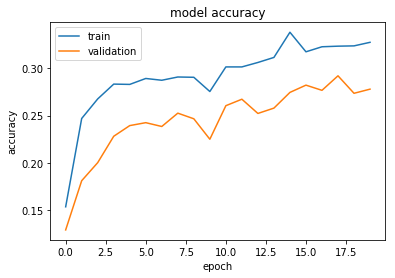

In [39]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['img_top_k_categorical_accuracy'])
plt.plot(history.history['val_img_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

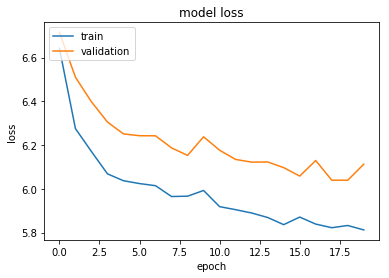

In [40]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
test_datagen = ImageDataGenerator()
test_data_path = target_attribute_model_folder + "data/test/"
test_iterator = DirectoryIteratorWithBoundingBoxes(test_data_path, test_datagen, bounding_boxes=dict_test, target_size=(200, 200))
scores = final_model.evaluate_generator(custom_generator(test_iterator), steps=100)

print('Multi target loss: ' + str(scores[0]))
print('Image loss: ' + str(scores[1]))
print('Bounding boxes loss: ' + str(scores[2]))
print('Image accuracy: ' + str(scores[3]))
print('Top-5 image accuracy: ' + str(scores[4]))
print('Bounding boxes error: ' + str(scores[5]))

Found 17987 images belonging to 135 classes.
Multi target loss: 6.105561723709107
Image loss: 4.240375964641571
Bounding boxes loss: 0.03748073566704988
Image accuracy: 0.07625
Top-5 image accuracy: 0.2834375
Bounding boxes error: 0.03748073566704988
